#### **Reminder**

Process the FloodEventDataset first to avoid any issues with displaying results. This can be done by either running train.py or eda.ipynb. You can confirm if it has been run by checking if the data/datasets/processed folder exists

### Imports

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from data import FloodEventDataset
from data.boundary_condition import BoundaryCondition
from data.dataset_normalizer import DatasetNormalizer
from matplotlib.patches import Patch
from typing import Tuple
from utils import file_utils, metric_utils

### Training Stats

In [2]:
training_stats_paths = [
    'physics_informed/train/NodeEdgeGNN_2025-10-02_12-29-08_base_train_stats.npz',
    'physics_informed/train/NodeEdgeGNN_2025-10-03_12-34-28_global_train_stats.npz',
    'physics_informed/train/NodeEdgeGNN_2025-10-04_14-56-06_local_train_stats.npz',
    'physics_informed/train/NodeEdgeGNN_2025-10-05_05-29-23_global_local_train_stats.npz',
]
labels = ['No Physics', 'Global', 'Local', 'Global and Local']

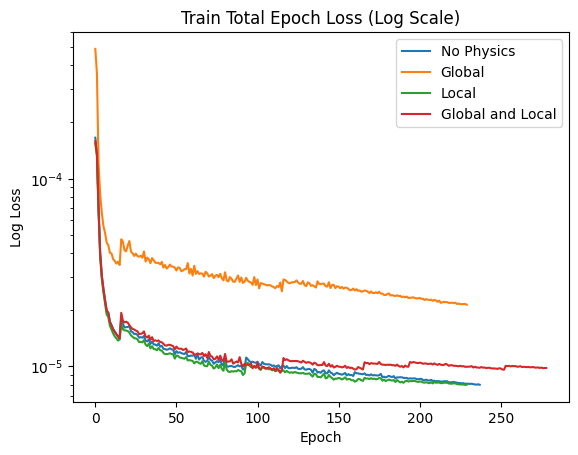

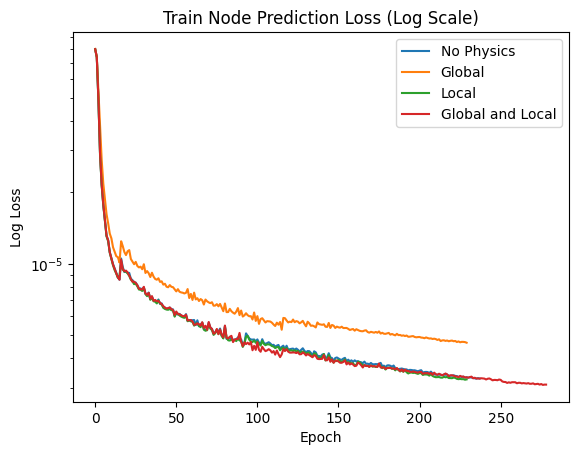

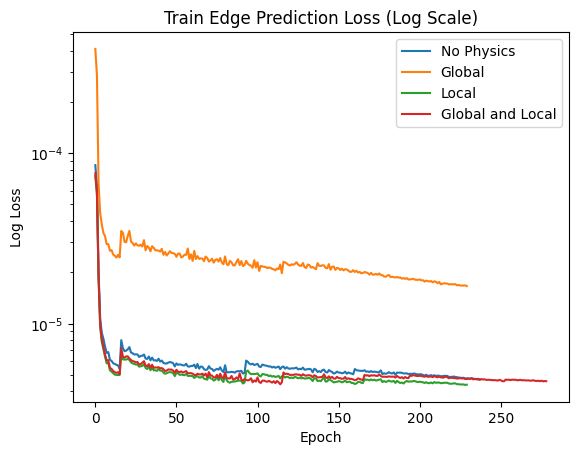

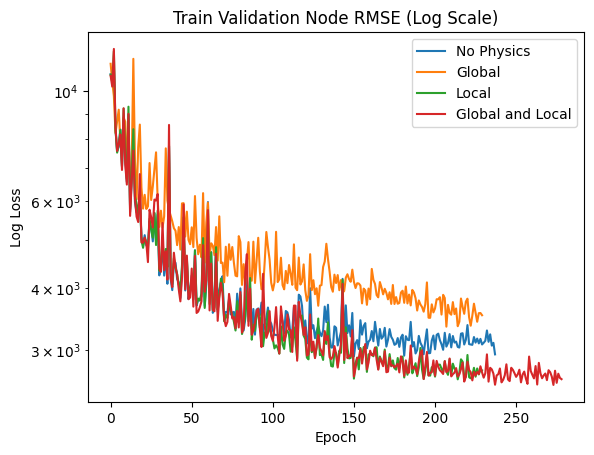

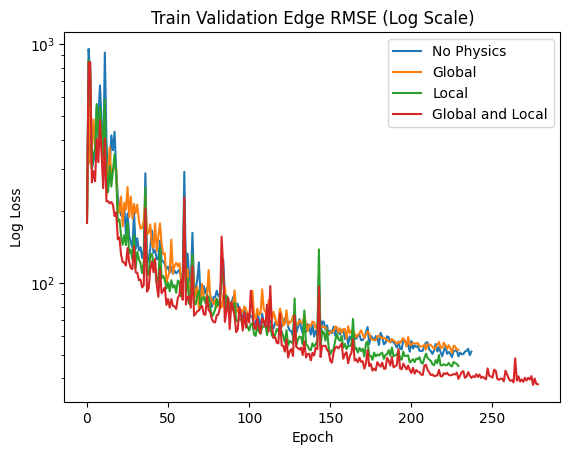

Metric 'orig_global_physics_loss' not found in any of the provided training stats paths.
Metric 'orig_local_physics_loss' not found in any of the provided training stats paths.


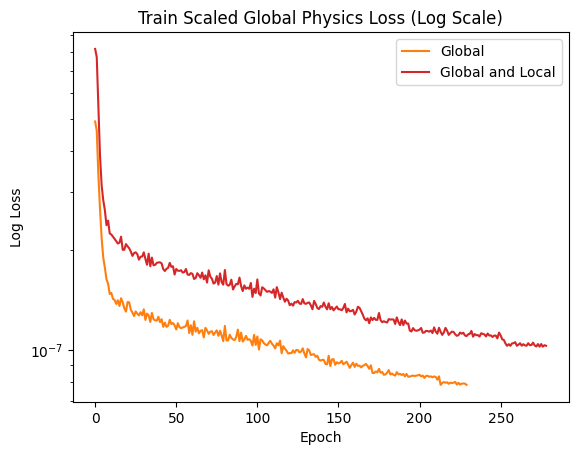

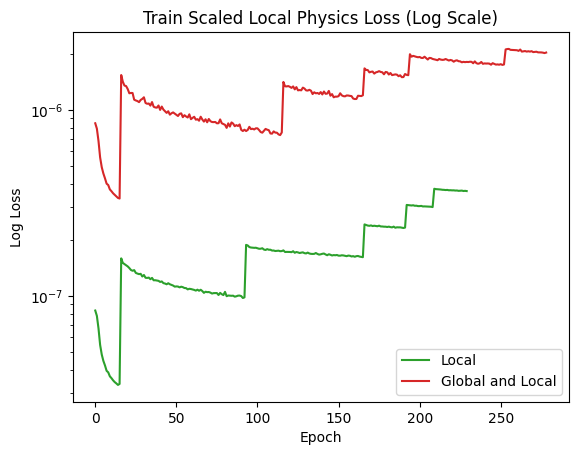

In [3]:
def plot_training_loss_for_all_models(stats_paths: list[str], metric: str, metric_name: str, start_epoch: int = 0, labels = None, log_scale: bool = False):
    is_metric_present = False
    for i, path in enumerate(stats_paths):
        label = labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        train_stats = np.load(path, allow_pickle=True)
        if metric not in train_stats:
            continue

        is_metric_present = True
        train_loss = train_stats[metric][start_epoch:]
        color = f'C{i % 10}'
        plt.plot(train_loss, label=label, color=color)

    if not is_metric_present:
        print(f"Metric '{metric}' not found in any of the provided training stats paths.")
        return

    title = metric_name if metric_name is not None else metric.replace('_', ' ').title()

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'Train {title} (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'Train {title}')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

start_epoch = 0
metrics = ['train_epoch_loss', 'prediction_loss', 'edge_prediction_loss', 'val_node_rmse', 'val_edge_rmse']
metric_names = ['Total Epoch Loss', 'Node Prediction Loss', 'Edge Prediction Loss', 'Validation Node RMSE', 'Validation Edge RMSE']

# Original Physics Loss
metrics += ['orig_global_physics_loss', 'orig_local_physics_loss']
metric_names += ['Global Physics Loss', 'Local Physics Loss']

# Scaled Physics Loss
metrics += ['global_physics_loss', 'local_physics_loss']
metric_names += ['Scaled Global Physics Loss', 'Scaled Local Physics Loss']

for metric, metric_name in zip(metrics, metric_names):
    plot_training_loss_for_all_models(training_stats_paths, metric, metric_name, start_epoch=start_epoch, labels=labels, log_scale=True)

Component 'global_physics_loss' not found in physics_informed/train/NodeEdgeGNN_2025-10-02_12-29-08_base_train_stats.npz. Skipping.
Component 'local_physics_loss' not found in physics_informed/train/NodeEdgeGNN_2025-10-02_12-29-08_base_train_stats.npz. Skipping.


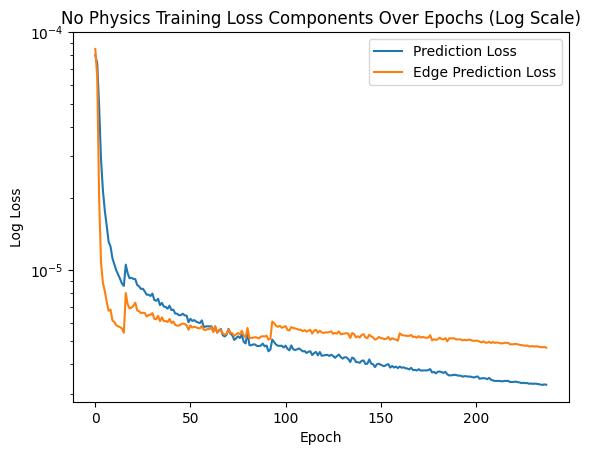

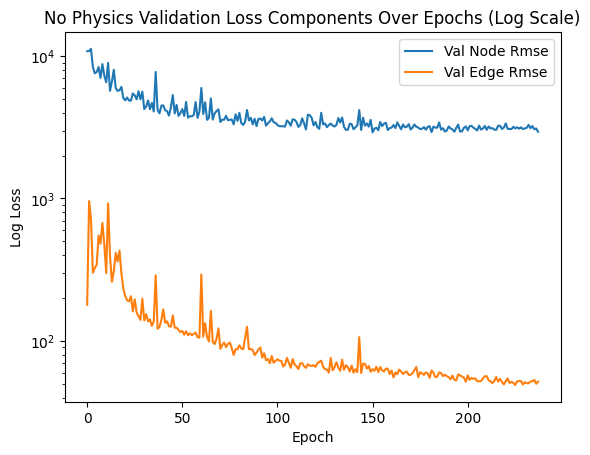

In [4]:
def plot_individual_training_loss(path: str, start_epoch: int = 0, model_label: str = '', log_scale: bool = False):
    loss_components = ['prediction_loss']
    model_name = os.path.basename(path).split('_')[0]
    if 'Edge' in model_name:
        loss_components.append('edge_prediction_loss')
    loss_components += ['global_physics_loss', 'local_physics_loss']

    for component in loss_components:
        train_loss = np.load(path, allow_pickle=True)
        if component not in train_loss:
            print(f"Component '{component}' not found in {path}. Skipping.")
            continue

        train_loss = train_loss[component][start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_loss, label=label)

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'{model_label} Training Loss Components Over Epochs (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'{model_label} Training Loss Components Over Epochs')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def plot_individual_training_val_loss(path: str, model_label: str = '', log_scale: bool = False):
    loss_components = ['val_node_rmse', 'val_edge_rmse']

    for component in loss_components:
        train_data = np.load(path, allow_pickle=True)
        if component not in train_data:
            print(f"Component '{component}' not found in {path}. Skipping.")
            continue

        train_data = train_data[component][start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_data, label=label)

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'{model_label} Validation Loss Components Over Epochs (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'{model_label} Validation Loss Components Over Epochs')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

PATH_IDX = 0 # Change this index to select different training stats paths
label = labels[PATH_IDX] if labels is not None else None
plot_individual_training_loss(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label, log_scale=True)
plot_individual_training_val_loss(training_stats_paths[PATH_IDX], model_label=label, log_scale=True)

Component 'val_global_mass_loss' not found in physics_informed/train/NodeEdgeGNN_2025-10-02_12-29-08_base_train_stats.npz. Skipping.
Component 'val_local_mass_loss' not found in physics_informed/train/NodeEdgeGNN_2025-10-02_12-29-08_base_train_stats.npz. Skipping.


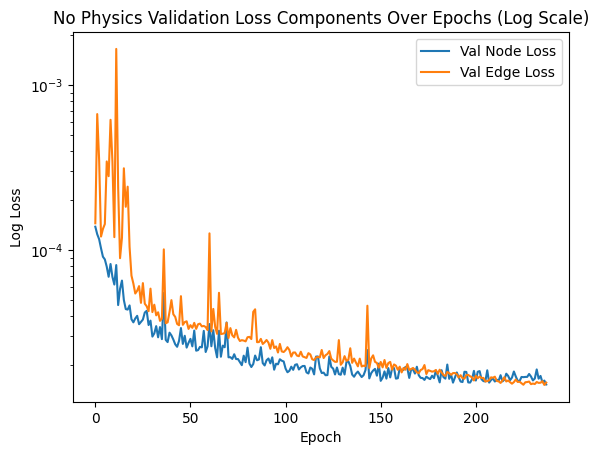

In [5]:
def plot_val_loss_components(path: str, model_label: str = '', log_scale: bool = False):
    loss_components = ['val_node_loss', 'val_edge_loss', 'val_global_mass_loss', 'val_local_mass_loss']

    for component in loss_components:
        train_data = np.load(path, allow_pickle=True)
        if component not in train_data:
            print(f"Component '{component}' not found in {path}. Skipping.")
            continue

        train_data = train_data[component][start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_data, label=label)

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'{model_label} Validation Loss Components Over Epochs (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'{model_label} Validation Loss Components Over Epochs')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_val_loss_components(training_stats_paths[PATH_IDX], model_label=label, log_scale=True)

In [6]:
# def plot_individual_training_loss_ratio(path: str, start_epoch: int = 0, model_label: str = None):
#     loss_ratios = ['edge_scaled_loss_ratios', 'global_scaled_loss_ratios', 'local_scaled_loss_ratios']
#     for ratio in loss_ratios:
#         data = np.load(path, allow_pickle=True)
#         if ratio not in data:
#             print(f"Ratio '{ratio}' not found in {path}. Skipping.")
#             continue

#         train_loss_ratio = data[ratio]
#         train_loss_ratio = train_loss_ratio[start_epoch:]
#         label = ratio.replace('_', ' ').title()
#         plt.plot(train_loss_ratio, label=label)

#     plt.plot(np.ones_like(train_loss_ratio), linestyle='--', color='red', label='Target Ratio (1.0)')
#     plt.title(f'{model_label if model_label is not None else ''} Training Loss Ratio Over Epochs')
#     plt.xticks(np.arange(len(train_loss_ratio), step=5))
#     plt.ylabel('Ratio')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()

# plot_individual_training_loss_ratio(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label)

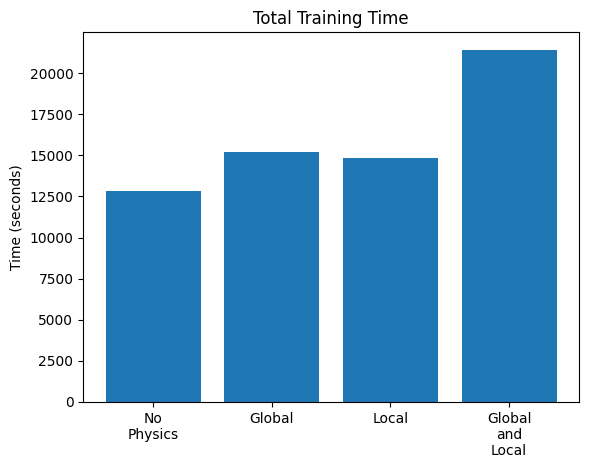

In [7]:
def plot_training_time_for_all_models(stats_paths: list[str], labels = None):
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in stats_paths]
    labels = [label.replace(' ', '\n') for label in labels]
    assert len(stats_paths) == len(labels), "Number of labels must match number of stats paths."

    all_train_time = []
    for path in stats_paths:
        train_time = np.load(path, allow_pickle=True)['train_time']
        all_train_time.append(train_time.item())

    plt.bar(labels, all_train_time)
    plt.title('Total Training Time')
    plt.ylabel('Time (seconds)')
    plt.show()

plot_training_time_for_all_models(training_stats_paths, labels=labels)

### Overall Metric Comparison

In [8]:
MESH_FACE_PATH = "data/datasets/raw/New_Geometry/faces.shp"

RUN_ID = 41
INCLUDE_EDGES = False

# metric_paths = [
#     f'physics_informed/test/NodeEdgeGNN_2025-10-16_22-21-56_base_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-10-17_07-59-47_global_and_local_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['Base', 'Global and Local']

# Main Results (Nodes)
metric_paths = [
    f'physics_informed/test/NodeEdgeGNN_2025-10-05_05-29-23_global_local_runid_{RUN_ID}_test_metrics.npz',
    f'baseline/hydrographnet_test_vol/HydroGraphNet_runid_{RUN_ID}_metrics.npz',
    f'baseline/test/GAT_2025-10-03_18-41-25_runid_{RUN_ID}_test_metrics.npz',
    f'baseline/test/GCN_2025-10-03_21-01-02_runid_{RUN_ID}_test_metrics.npz',
]
labels = ['DUALFloodGNN', 'HydroGraphNet', 'GAT', 'GCN']

# Main Results (Edges)
# metric_paths = [
#     f'physics_informed/test/NodeEdgeGNN_2025-10-05_05-29-23_global_local_runid_{RUN_ID}_test_metrics.npz',
#     f'baseline/edge_test/EdgeGAT_2025-10-16_23-08-59_runid_{RUN_ID}_test_metrics.npz',
#     f'baseline/edge_test/EdgeGCN_2025-10-17_22-51-33_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['DUALFloodGNN', 'EdgeGAT', 'EdgeGCN']

# Loss Ablation Study
# metric_paths = [
#     f'physics_informed/test/NodeEdgeGNN_2025-10-02_12-29-08_base_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-10-03_12-34-28_global_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-10-04_14-56-06_local_runid_{RUN_ID}_test_metrics.npz',
#     f'physics_informed/test/NodeEdgeGNN_2025-10-05_05-29-23_global_local_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['Base', 'Global', 'Local', 'Global and Local']

In [9]:
# Double check targets are the same
# EPS = 1e-5
EPS = 1e-1 # For HydroGraphNet: compare with a larger tolerance due to differences in normalization
comparison_target = None
comparison_edge_target = None
for path in metric_paths:
    print('Checking target for', path)
    data = np.load(path, allow_pickle=True)
    target = data['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'
    
    if 'edge_target' not in data:
        continue

    edge_target = data['edge_target']
    if comparison_edge_target is None:
        comparison_edge_target = edge_target
    else:
        assert np.all((comparison_edge_target - edge_target) < EPS), f'Edge targets are not equal for {path}'

Checking target for physics_informed/test/NodeEdgeGNN_2025-10-05_05-29-23_global_local_runid_41_test_metrics.npz
Checking target for baseline/hydrographnet_test_vol/HydroGraphNet_runid_41_metrics.npz
Checking target for baseline/test/GAT_2025-10-03_18-41-25_runid_41_test_metrics.npz
Checking target for baseline/test/GCN_2025-10-03_21-01-02_runid_41_test_metrics.npz


In [10]:
def get_x_ticks_from_timestamps(metric_paths: list[str]) -> Tuple[list[str], str]:
    delta_t = None
    len_timestamps = None
    for path in metric_paths:
        data = np.load(path, allow_pickle=True)
        if 'timestamps' not in data:
            continue
        timestamps = data['timestamps']
        if timestamps is None or len(timestamps) == 0:
            continue

        assert len(timestamps) > 1, f"Expected more than one timestamp in {path}, found {len(timestamps)}."
        path_delta_t = timestamps[1] - timestamps[0]
        if delta_t is None:
            delta_t = path_delta_t
        assert delta_t == path_delta_t, f"Timestep interval mismatch for {path}: {delta_t} vs {path_delta_t}"
        if len_timestamps is None:
            len_timestamps = len(timestamps)
        assert len_timestamps == len(timestamps), f"Number of timestamps mismatch for {path}: {len_timestamps} vs {len(timestamps)}"
    
    if delta_t is None:
        x_ticks = np.arange(0, data['pred'].shape[0], step=10)
        return x_ticks, x_ticks, 'Timestep'

    TIME_INTERVAL_IN_HOURS = 12
    delta_t = delta_t.item()
    delta_t_in_hours = delta_t.total_seconds() / 3600
    step = TIME_INTERVAL_IN_HOURS / delta_t_in_hours
    x_ticks = np.concat([np.arange(0, len(timestamps), step=step), np.array([len(timestamps)-1])], axis=0)
    x_tick_labels = x_ticks * delta_t_in_hours
    return x_ticks, x_tick_labels, f'Time (hours)'


def plot_metric_for_all_models(metric_paths: list[str], metric: str, metric_name: str = None, labels: list[str] = None, log_scale: bool = False):
    split_metric = metric.split('_') 
    if metric_name is None:
        metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)
        if metric not in data or all(data[metric].shape) == 0:
            print(f"Metric '{metric}' is empty for path {path}. Skipping.")
            continue
        data = data[metric]

        print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        if len(path.split('/')[-1].split('_')) == 4:
            label = f'{label} ({path.split('/')[-1].split('_')[3]})'

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(data, label=label, color=f'C{i % 10}')

    if log_scale:
        plt.yscale('log')
        plt.ylabel(f'{metric_name} (Log Scale)')
        plt.title(f'Test {metric_name} for Event {event_name} (Log Scale)')
    else:
        plt.title(f'Test {metric_name} for Event {event_name}')
        plt.ylabel(metric_name)

    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)
    plt.legend(framealpha=0)
    plt.show()

Average Node RMSE for NodeEdgeGNN: 1970.1920
Average Node RMSE for HydroGraphNet: 6277.1655
Average Node RMSE for GAT: 6955.7041
Average Node RMSE for GCN: 7053.1885


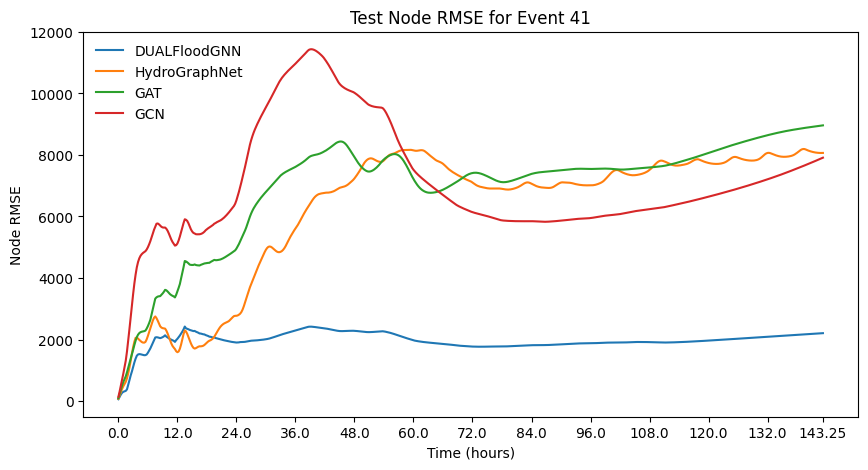

Average Node MAE for NodeEdgeGNN: 961.9008
Average Node MAE for HydroGraphNet: 3382.7874
Average Node MAE for GAT: 3240.6238
Average Node MAE for GCN: 4502.8608


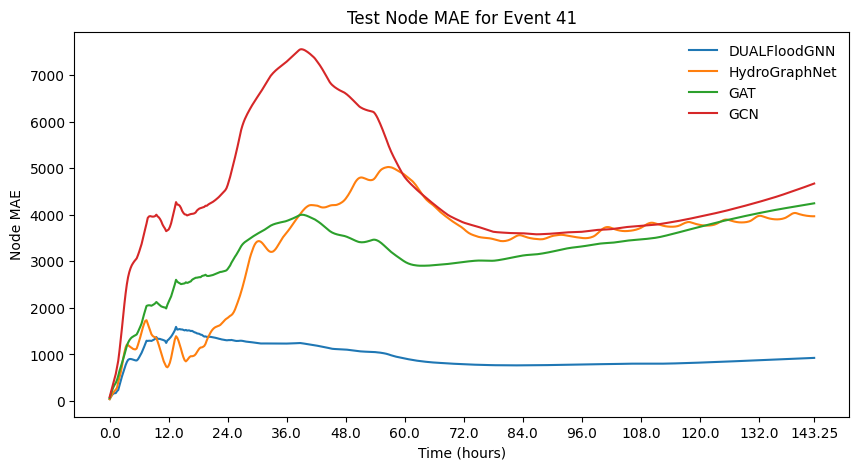

Average Node NSE for NodeEdgeGNN: 0.9592
Average Node NSE for HydroGraphNet: 0.4655
Average Node NSE for GAT: 0.4017
Average Node NSE for GCN: 0.5195


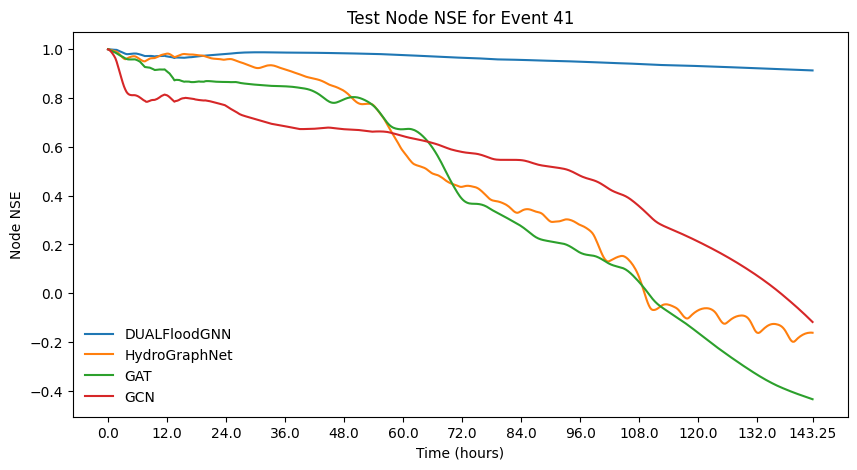

Average Node CSI (Volume Threshold) for NodeEdgeGNN: 0.8060
Average Node CSI (Volume Threshold) for HydroGraphNet: 0.5250
Average Node CSI (Volume Threshold) for GAT: 0.5921
Average Node CSI (Volume Threshold) for GCN: 0.5275


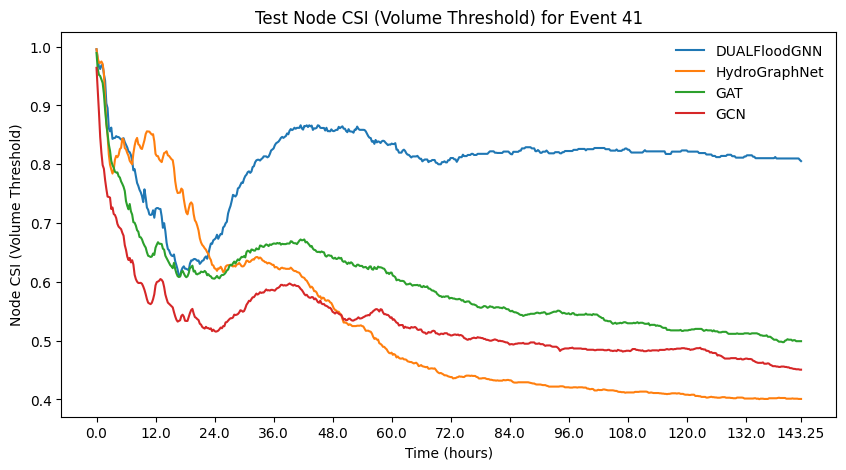

Average Global Mass Loss for NodeEdgeGNN: 419.1366
Average Global Mass Loss for HydroGraphNet: -327549.4054
Average Global Mass Loss for GAT: 4381.7350
Average Global Mass Loss for GCN: 6552.5137


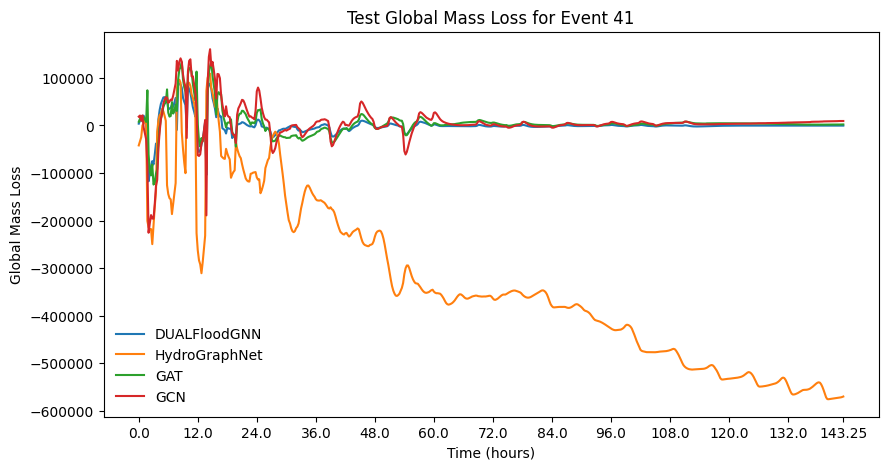

Average Local Mass Loss for NodeEdgeGNN: -1111.4840
Metric 'local_mass_loss' is empty for path baseline/hydrographnet_test_vol/HydroGraphNet_runid_41_metrics.npz. Skipping.
Average Local Mass Loss for GAT: 242.5109
Average Local Mass Loss for GCN: 475.4159


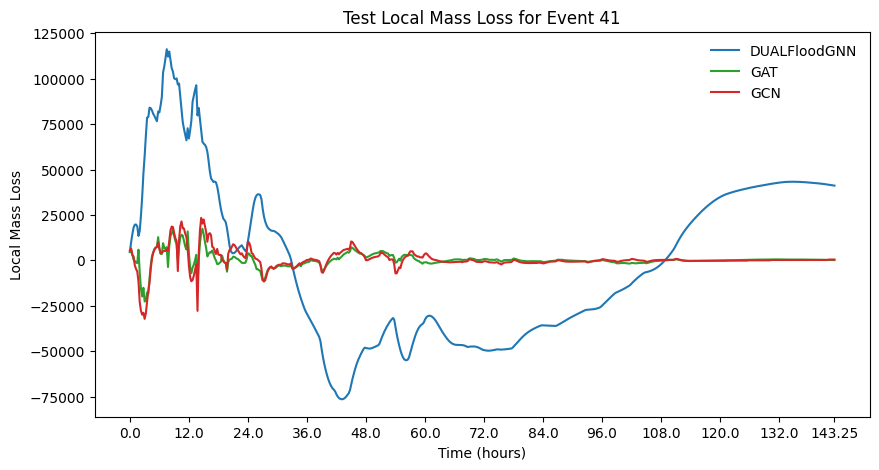

In [11]:
metrics = ['rmse', 'mae', 'nse', 'csi']
metric_names = ['Node RMSE', 'Node MAE', 'Node NSE', 'Node CSI (Volume Threshold)']

# Flooded Node Metrics
# metrics += ['rmse_flooded', 'mae_flooded', 'nse_flooded']
# metric_names += ['Node RMSE (flooded)', 'Node MAE (flooded)', 'Node NSE (flooded)']

# Physics Metrics
metrics += ['global_mass_loss', 'local_mass_loss']
metric_names += ['Global Mass Loss', 'Local Mass Loss']

# Metrics for edge prediction
if INCLUDE_EDGES:
    metrics += ['edge_rmse', 'edge_mae', 'edge_nse']
    metric_names += ['Edge RMSE', 'Edge MAE', 'Edge NSE']

for metric, metric_name in zip(metrics, metric_names):
    plot_metric_for_all_models(metric_paths, metric, metric_name=metric_name, labels=labels, log_scale=False)

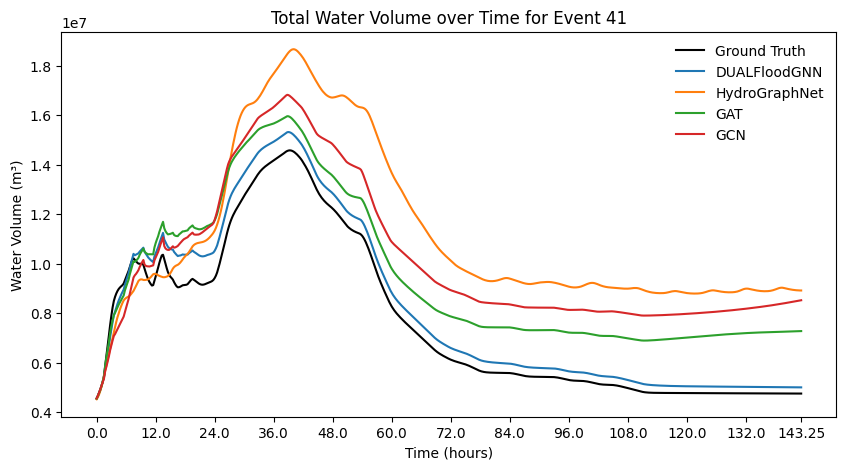

In [12]:
def plot_total_water_volume_for_all_models(metric_paths: list[str], ground_truth: np.ndarray = None, labels: list[str] = None, end_timestep: int = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'Total Water Volume over Time for Event {event_name}')

    if ground_truth is not None:
        gt_total_volume = ground_truth.sum(axis=1)
        if end_timestep is not None:
            gt_total_volume = gt_total_volume[:end_timestep]
        plt.plot(gt_total_volume, label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for path {path}: {data.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]
        if labels is not None:
            label = labels[i] if i < len(labels) else label

        pred_total_volume = data.sum(axis=1)
        if end_timestep is not None:
            pred_total_volume = pred_total_volume[:end_timestep]
        plt.plot(pred_total_volume, label=label)

    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)
    plt.ylabel('Water Volume (m³)')
    plt.legend(framealpha=0)
    plt.show()

vol_ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
plot_total_water_volume_for_all_models(metric_paths, ground_truth=vol_ground_truth, labels=labels)

### Node Analysis

In [13]:
# Nodes connected to boundary conditions
BOUNDARY_NODE_IDX = [718, 434, 858]
# Top 4 highest water differences
NODE_IDX_MAP = {
    13: [1026, 443, 208, 459], # Run ID 13
    14: [1026, 443, 459, 444], # Run ID 14
    15: [1022, 1023, 1026, 1082], # Run ID 15
    16: [1022, 1023, 1026, 1082], # Run ID 16
}
# SELECTED_NODE_IDX = NODE_IDX_MAP[RUN_ID] + BOUNDARY_NODE_IDX
SELECTED_NODE_IDX = [1082, 1023, 534, 459] # Nodes located at the river
node_idxs = SELECTED_NODE_IDX # + BOUNDARY_NODE_IDX

def plot_water_volume_for_node(node_idx: int, water_volume: np.ndarray, num_timesteps: int = None):
    if num_timesteps is None:
        num_timesteps = water_volume.shape[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')
    plt.plot(water_volume[:num_timesteps, node_idx], color='black')
    plt.show()

# for node_idx in node_idxs:
#     peak_wv = vol_ground_truth[:, node_idx].max()
#     peak_wv_timestep = vol_ground_truth[:, node_idx].argmax()
#     print(f"(Run ID {RUN_ID}) Peak water volume for node {node_idx}: {peak_wv} (timestep {peak_wv_timestep})")

#     # plot_water_volume_for_node(node_idx, vol_ground_truth)

In [14]:
def get_edge_index(constant_values_path: str):
    constant_values = np.load(constant_values_path, allow_pickle=True)
    edge_index = constant_values['edge_index']
    return edge_index

def plot_node_values_for_all_models(metric_paths: list[str],
                                    node_idx: int,
                                    edge_index: np.ndarray,
                                    ground_truths: Tuple[np.ndarray, np.ndarray] = (None, None),
                                    labels: list[str] = None):
    vol_ground_truth, flow_ground_truth = ground_truths

    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    plt.figure(figsize=(8, 4))
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    handles = []

    # Water Volume
    # plt.text(1, 0.3, 'Water Volume', transform=ax[0].transAxes, rotation=270, fontsize=12)
    plt.ylabel('Water Volume (m³)')
    plt.xlabel(xlabel)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)

    if vol_ground_truth is not None:
       gt_line, = plt.plot(vol_ground_truth[:, node_idx], label='Ground Truth', color='black')
       handles.append(gt_line)

    data_shape = None
    for i, data in enumerate(metrics):
        pred = data['pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

        line, = plt.plot(pred[:, node_idx], label=labels[i])
        handles.append(line)

    plt.title(f'Metrics Over Time for Node {node_idx}')
    plt.legend(handles=handles, labels=['Ground Truth', *labels])
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()

def plot_node_and_edge_values_for_all_models(metric_paths: list[str],
                                             node_idx: int,
                                             edge_index: np.ndarray,
                                             ground_truths: Tuple[np.ndarray, np.ndarray] = (None, None),
                                             labels: list[str] = None):
    vol_ground_truth, flow_ground_truth = ground_truths

    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    handles = []

    # Water Volume
    ax[0].text(1, 0.3, 'Water Volume', transform=ax[0].transAxes, rotation=270, fontsize=12)
    ax[0].set_ylabel('Water Volume (m³)')
    ax[0].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if vol_ground_truth is not None:
       gt_line, = ax[0].plot(vol_ground_truth[:, node_idx], label='Ground Truth', color='black')
       handles.append(gt_line)

    data_shape = None
    for i, data in enumerate(metrics):
        pred = data['pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

        line, = ax[0].plot(pred[:, node_idx], label=labels[i])
        handles.append(line)

    connected_edges = np.nonzero(np.any(edge_index == node_idx, axis=0))[0]
    inflow_edges = connected_edges[edge_index[:, connected_edges][1] == node_idx]
    outflow_edges = connected_edges[edge_index[:, connected_edges][0] == node_idx]

    # Inflow Water Flow
    def get_inflow(flow: np.ndarray) -> np.ndarray:
        from_inflow_edges = flow[:, inflow_edges]
        from_inflow_edges[from_inflow_edges < 0] = 0 # Negative inflow = outflow
        from_outflow_edges = -flow[:, outflow_edges] # Negative outflow = inflow
        from_outflow_edges[from_outflow_edges < 0] = 0
        return from_inflow_edges.sum(axis=1) + from_outflow_edges.sum(axis=1) 

    ax[1].text(1, 0.3, 'Water Inflow', transform=ax[1].transAxes, rotation=270, fontsize=12)
    ax[1].set_ylabel('Water Flow (m³/s)')
    ax[1].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if flow_ground_truth is not None:
        ax[1].plot(get_inflow(flow_ground_truth), label='Ground Truth', color='black')

    data_shape = None
    for i, data in enumerate(metrics):
        edge_pred = data['edge_pred']

        if data_shape is None:
            data_shape = edge_pred.shape
        assert edge_pred.shape == data_shape, f"Data shape mismatch for path {i}: {edge_pred.shape} vs {data_shape}"

        ax[1].plot(get_inflow(edge_pred), label=labels[i])

    # Outflow Water Flow
    def get_outflow(flow: np.ndarray) -> np.ndarray:
        from_outflow_edges = flow[:, outflow_edges]
        from_outflow_edges[from_outflow_edges < 0] = 0 # Negative outflow = inflow
        from_inflow_edges = -flow[:, inflow_edges] # Negative inflow = outflow
        from_inflow_edges[from_inflow_edges < 0] = 0
        return from_outflow_edges.sum(axis=1) + from_inflow_edges.sum(axis=1)

    ax[2].text(1, 0.3, 'Water Outflow', transform=ax[2].transAxes, rotation=270, fontsize=12)
    ax[2].set_ylabel('Water Flow (m³/s)')
    ax[2].set_xlabel(xlabel)
    ax[2].set_xticks(ticks=x_ticks, labels=x_ticks_labels)

    if flow_ground_truth is not None:
        ax[2].plot(get_outflow(flow_ground_truth), label='Ground Truth', color='black')

    data_shape = None
    for i, data in enumerate(metrics):
        edge_pred = data['edge_pred']

        if data_shape is None:
            data_shape = edge_pred.shape
        assert edge_pred.shape == data_shape, f"Data shape mismatch for path {i}: {edge_pred.shape} vs {data_shape}"

        ax[2].plot(get_outflow(edge_pred), label=labels[i])

    fig.suptitle(f'Metrics Over Time for Node {node_idx}')
    fig.legend(handles=handles, labels=['Ground Truth', *labels], loc='upper right')
    fig.subplots_adjust(left=0.15)
    fig.tight_layout()

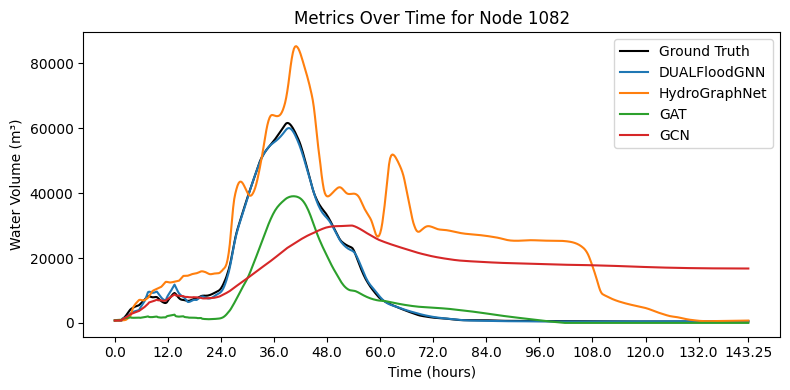

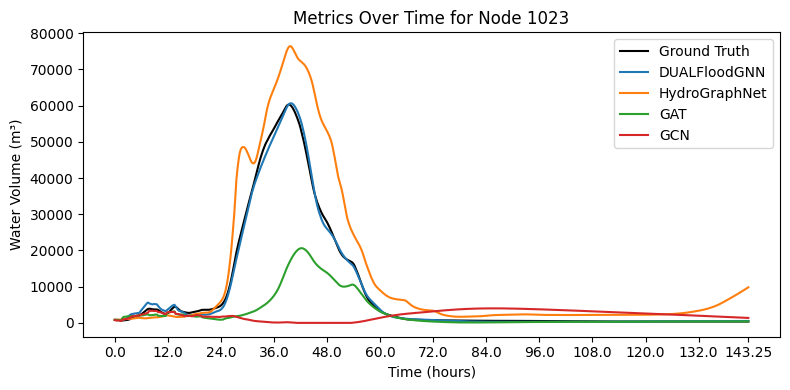

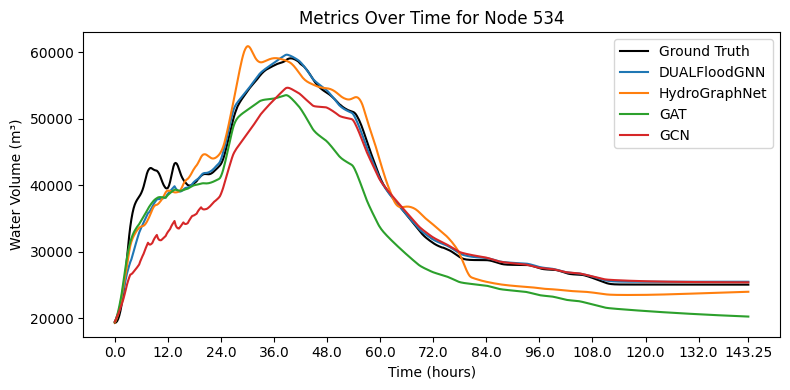

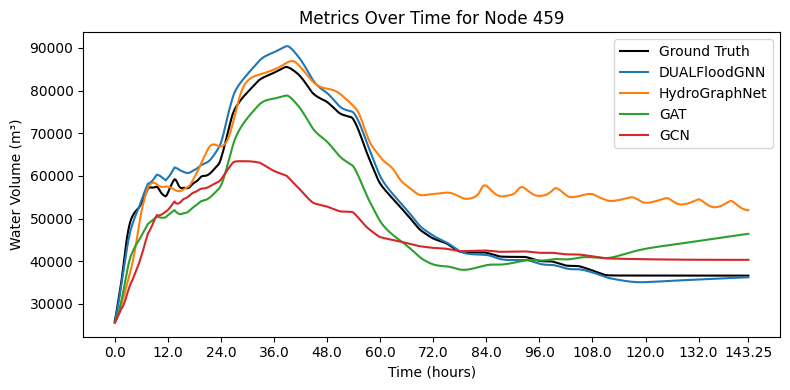

In [15]:
constant_values_path = 'data/datasets/processed/constant_values.npz'
edge_index = get_edge_index(constant_values_path)
flow_ground_truth = np.load(metric_paths[0], allow_pickle=True)['edge_target'] if INCLUDE_EDGES else None
plot_for_all_models_func = plot_node_and_edge_values_for_all_models if INCLUDE_EDGES else plot_node_values_for_all_models

for node_idx in node_idxs:
    plot_for_all_models_func(metric_paths,
                             node_idx,
                             edge_index,
                             ground_truths=(vol_ground_truth, flow_ground_truth),
                             labels=labels)

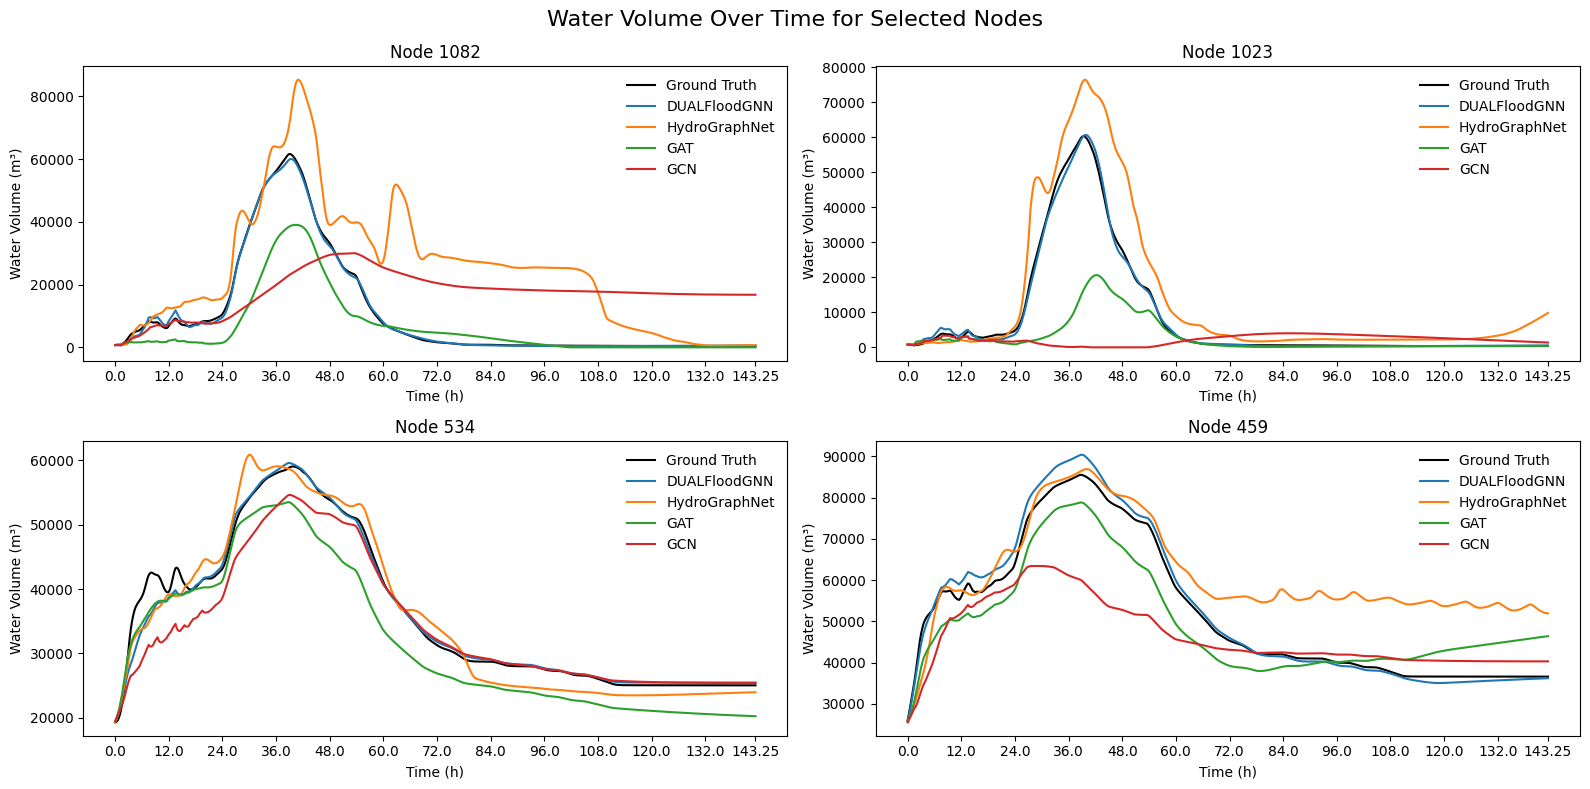

In [16]:
def plot_cell_vol_as_single_plot(metric_paths: list[str],
                                 node_idxs: list[int],
                                 vol_ground_truth: np.ndarray = None,
                                 labels: list[str] = None):
    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    # Handle single node_idx for backward compatibility
    if isinstance(node_idxs, int):
        node_idxs = [node_idxs]
    
    # Create subplots for multiple nodes
    num_nodes = len(node_idxs)
    ncols = min(2, num_nodes)  # Max 2 columns
    nrows = (num_nodes + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows))
    if num_nodes == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes if ncols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)

    for node_idx_pos, node_idx in enumerate(node_idxs):
        ax = axes[node_idx_pos] if num_nodes > 1 else axes[0]
        handles = []

        # Water Volume
        ax.set_ylabel('Water Volume (m³)')
        ax.set_xlabel('Time (h)')
        ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

        if vol_ground_truth is not None:
           gt_line, = ax.plot(vol_ground_truth[:, node_idx], label='Ground Truth', color='black')
           handles.append(gt_line)

        data_shape = None
        for i, data in enumerate(metrics):
            pred = data['pred']

            if data_shape is None:
                data_shape = pred.shape
            assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

            line, = ax.plot(pred[:, node_idx], label=labels[i])
            handles.append(line)

        ax.set_title(f'Node {node_idx}')
        ax.legend(handles=handles, labels=['Ground Truth', *labels] if vol_ground_truth is not None else labels, framealpha=0)

    # Hide unused subplots
    for i in range(num_nodes, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Water Volume Over Time for Selected Nodes', fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()

plot_cell_vol_as_single_plot(metric_paths, node_idxs, vol_ground_truth=vol_ground_truth, labels=labels)

In [17]:
for node in node_idxs:
    print(f'Calculating NSE for node {node}...')
    node_gt = torch.Tensor(vol_ground_truth[:, node])
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']
        node_pred = torch.Tensor(pred[:, node])
        nse = metric_utils.NSE(node_pred, node_gt)
        label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        print(f'\tNSE for {label}: {nse:.4f}')

Calculating NSE for node 1082...
	NSE for DUALFloodGNN: 0.9987
	NSE for HydroGraphNet: -0.1710
	NSE for GAT: 0.7184
	NSE for GCN: -0.0760
Calculating NSE for node 1023...
	NSE for DUALFloodGNN: 0.9972
	NSE for HydroGraphNet: 0.7174
	NSE for GAT: 0.2780
	NSE for GCN: -0.2860
Calculating NSE for node 534...
	NSE for DUALFloodGNN: 0.9850
	NSE for HydroGraphNet: 0.9517
	NSE for GAT: 0.8304
	NSE for GCN: 0.8986
Calculating NSE for node 459...
	NSE for DUALFloodGNN: 0.9820
	NSE for HydroGraphNet: 0.4822
	NSE for GAT: 0.8387
	NSE for GCN: 0.5161


In [18]:
def plot_edge_values_for_all_models(metric_paths: list[str],
                                    edge_idx: int,
                                    ground_truth: np.ndarray = None,
                                    labels: list[str] = None):
    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    plt.figure(figsize=(8, 4))
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    handles = []

    plt.ylabel('Water Flow (m³/s)')
    plt.xlabel(xlabel)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)

    if ground_truth is not None:
       gt_line, = plt.plot(ground_truth[:, edge_idx], label='Ground Truth', color='black')
       handles.append(gt_line)

    data_shape = None
    for i, data in enumerate(metrics):
        pred = data['edge_pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

        line, = plt.plot(pred[:, edge_idx], label=labels[i])
        handles.append(line)

    plt.title(f'Metrics Over Time for Edge {edge_idx}')
    plt.legend(handles=handles, labels=['Ground Truth', *labels])
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()

In [19]:
# Edges connected to boundary nodes
BOUNDARY_EDGE_IDX = [2470, 2471, 2472]
# Top 4 highest water differences
EDGE_IDX_MAP = {
    # Add here if you want to set specific edges for different RUN_IDs
}
# SELECTED_EDGE_IDX = EDGE_IDX_MAP[RUN_ID] + BOUNDARY_EDGE_IDX
# SELECTED_EDGE_IDX = [1609, 1594, 2089, 600] # Edges located at the river
SELECTED_EDGE_IDX = [1609, 1101, 1894, 559] # Edges located at the river
edge_idxs = SELECTED_EDGE_IDX # + BOUNDARY_EDGE_IDX

if INCLUDE_EDGES:
    for edge_idx in edge_idxs:
        plot_edge_values_for_all_models(metric_paths,
                                        edge_idx,
                                        flow_ground_truth,
                                        labels=labels)

In [20]:
def plot_edge_flow_as_single_plot(metric_paths: list[str],
                                 edge_idxs: list[int],
                                 flow_ground_truth: np.ndarray = None,
                                 labels: list[str] = None):
    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    # Handle single edge_idx for backward compatibility
    if isinstance(edge_idxs, int):
        edge_idxs = [edge_idxs]
    
    # Create subplots for multiple edges
    num_edges = len(edge_idxs)
    ncols = min(2, num_edges)  # Max 2 columns
    nrows = (num_edges + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows))
    if num_edges == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes if ncols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)

    for edge_idx_pos, edge_idx in enumerate(edge_idxs):
        ax = axes[edge_idx_pos] if num_edges > 1 else axes[0]
        handles = []

        ax.set_ylabel('Water Flow (m³/s)')
        ax.set_xlabel('Time (h)')
        ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

        if flow_ground_truth is not None:
           gt_line, = ax.plot(flow_ground_truth[:, edge_idx], label='Ground Truth', color='black')
           handles.append(gt_line)

        data_shape = None
        for i, data in enumerate(metrics):
            pred = data['edge_pred']

            if data_shape is None:
                data_shape = pred.shape
            assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

            line, = ax.plot(pred[:, edge_idx], label=labels[i])
            handles.append(line)

        ax.set_title(f'Edge {edge_idx}')
        ax.legend(handles=handles, labels=['Ground Truth', *labels] if flow_ground_truth is not None else labels, framealpha=0)

    # Hide unused subplots
    for i in range(num_edges, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Water Flow Over Time for Selected Edges', fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()

if INCLUDE_EDGES:
    plot_edge_flow_as_single_plot(metric_paths, edge_idxs, flow_ground_truth=flow_ground_truth, labels=labels)

### Flood Map Analysis

In [ ]:
def map_centers_to_polygons(polygons_gdf, centers_gdf):
    assert len(polygons_gdf) == len(centers_gdf), "Length of mesh cells DataFrame and cell centers DataFrame must be the same. Double check if you have removed ghost nodes from the cell centers."

    # Create a copy of the centers dataframe to preserve original data
    result_gdf = centers_gdf.copy()

    # Store original center coordinates for reference
    result_gdf['center_x'] = centers_gdf.geometry.x
    result_gdf['center_y'] = centers_gdf.geometry.y

    # Create spatial index for efficient querying
    spatial_index = polygons_gdf.sindex

    # Initialize list to store matched polygons
    matched_polygons = []
    matched_polygon_indices = []

    # For each center point, find the containing polygon
    for idx, center in centers_gdf.iterrows():
        center_point = center.geometry

        # Get candidate polygons using spatial index
        possible_matches_idx = list(spatial_index.intersection(center_point.bounds))
        possible_matches = polygons_gdf.iloc[possible_matches_idx]

        # Find which polygon actually contains the point
        match_found = False
        for poly_idx, poly_row in enumerate(possible_matches):
            if poly_row.contains(center_point):
                matched_polygons.append(poly_row)
                matched_polygon_indices.append(poly_idx)
                match_found = True
                break

        # If no match found, append None
        if not match_found:
            matched_polygons.append(None)
            matched_polygon_indices.append(None)

    # Replace geometry with matched polygons
    result_gdf['geometry'] = matched_polygons
    result_gdf['polygon_index'] = matched_polygon_indices

    # Check for unmatched centers
    unmatched = result_gdf[result_gdf['geometry'].isna()]
    if len(unmatched) > 0:
        print(f"Warning: {len(unmatched)} cell centers could not be matched to polygons")
        print(f"Unmatched indices: {unmatched.index.tolist()}")

    return result_gdf

In [22]:
def get_max_flood_map(metric_path: str, property: str) -> np.ndarray:
    per_cell_volume = np.load(metric_path, allow_pickle=True)[property]
    max_flood_map = per_cell_volume.max(axis=0)
    return max_flood_map

def get_node_df(config: dict, run_id: str, no_ghost: bool = True) -> gpd.GeoDataFrame:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']
    nodes_shp_file = dataset_parameters['nodes_shp_file']
    nodes_shp_path = os.path.join(root_dir, 'raw', nodes_shp_file)
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
        dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
        summary_df = pd.read_csv(dataset_summary_path)
        summary_df = summary_df[summary_df['Run_ID'] == run_id]
        hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

        inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
        outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

        bc = BoundaryCondition(root_dir=root_dir,
                               hec_ras_file=hec_ras_file,
                               inflow_boundary_nodes=inflow_boundary_nodes,
                               outflow_boundary_nodes=outflow_boundary_nodes,
                               saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
        node_df = node_df[~node_df['CC_index'].isin(bc.ghost_nodes)]

    return node_df

def get_axis_from_subplot(axes, nrows: int, ncols: int, index: int) -> plt.Axes:
    if nrows == 1:
        return axes[index]
    else:
        ax_row = index // ncols
        ax_col = index % ncols
        return axes[ax_row, ax_col]

def hide_remaining_axes(axes, start_index: int, nrows: int, ncols: int):
    total_axes = nrows * ncols
    for i in range(start_index, total_axes):
        ax = get_axis_from_subplot(axes, nrows, ncols, i)
        ax.set_visible(False)
        ax.set_axis_off()

def plot_cell_map(axis, gpdf: gpd.GeoDataFrame, value: np.ndarray, title: str, cmap = None, vmin: float = None, vmax: float = None):
    value_column = 'is_flooded'
    if cmap is None:
        cmap = plt.get_cmap('viridis') 

    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        # 'linewidth': 0.3,
        # 'markersize': 3,
        # 'linewidth': 0.5,
        # 'edgecolor': 'black',
        # 'alpha': 0.9,
    }

    # Add vmin/vmax if provided for consistent color scaling
    if vmin is not None and vmax is not None:
        shared_plot_kwargs['vmin'] = vmin
        shared_plot_kwargs['vmax'] = vmax

    gpdf[value_column] = value
    plot_obj = gpdf.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

    return plot_obj

def plot_max_vol_map_for_all_models(metric_paths: list[str],
                                    node_df: gpd.GeoDataFrame,
                                    ground_truth: np.ndarray = None,
                                    labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    cmap = plt.get_cmap('viridis_r')
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max Flood Volume Maps for Event {event_name}')
    index = 0

    # Get max flood maps for all paths
    max_flood_maps = []
    vmin = np.inf if ground_truth is None else ground_truth.min()
    vmax = -np.inf if ground_truth is None else ground_truth.max()
    data_shape = None
    for path in metric_paths:
        pred = get_max_flood_map(path, 'pred')
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        # vmin = min(vmin, pred.min())
        # vmax = max(vmax, pred.max())
        max_flood_maps.append(pred)

    # Plot ground truth
    plot_obj = None
    if ground_truth is not None:
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, node_df, ground_truth, title='Ground Truth', 
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    # Plot predictions
    for i, map_data in enumerate(max_flood_maps):
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, node_df, map_data, title=labels[i],
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    if plot_obj is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
        cbar.set_label('Water Volume (m³)', rotation=270, labelpad=15)
    
    hide_remaining_axes(ax, index, nrows, ncols)
    plt.subplots_adjust(right=0.9)
    # plt.tight_layout()
    plt.show()

In [23]:
max_flood_map_gt = get_max_flood_map(metric_paths[0], 'target')

print(f'Calculating RMSE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    rmse = metric_utils.RMSE(pred_max_flood_map, torch.Tensor(max_flood_map_gt))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tRMSE for {label}: {rmse:.4f}')

print(f'Calculating MAE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    mae = metric_utils.MAE(pred_max_flood_map, torch.Tensor(max_flood_map_gt))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tMAE for {label}: {mae:.4f}')

Calculating RMSE for max flood maps...
	RMSE for DUALFloodGNN: 2889.5515
	RMSE for HydroGraphNet: 7954.3970
	RMSE for GAT: 10848.7051
	RMSE for GCN: 12181.7900
Calculating MAE for max flood maps...
	MAE for DUALFloodGNN: 1650.3818
	MAE for HydroGraphNet: 4716.5498
	MAE for GAT: 5407.6060
	MAE for GCN: 8546.3926


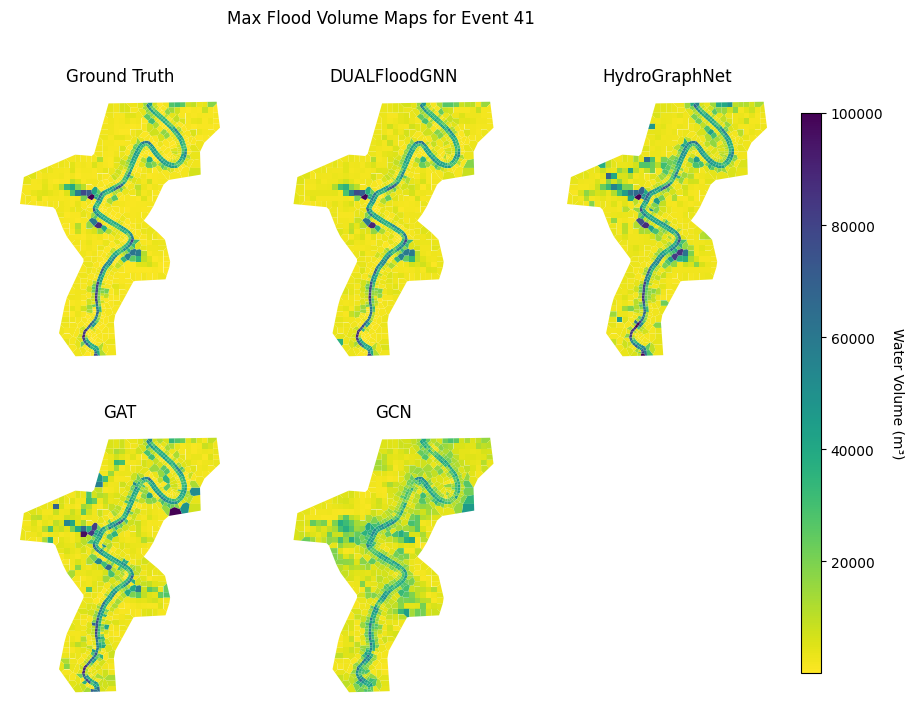

In [24]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

gpdf = get_node_df(config, RUN_ID, no_ghost=True)
if MESH_FACE_PATH is not None:
    cells_df = gpd.read_file(MESH_FACE_PATH).polygonize()
    gpdf = map_centers_to_polygons(cells_df, gpdf)

plot_max_vol_map_for_all_models(metric_paths,
                                  gpdf,
                                  labels=labels,
                                  ground_truth=max_flood_map_gt)

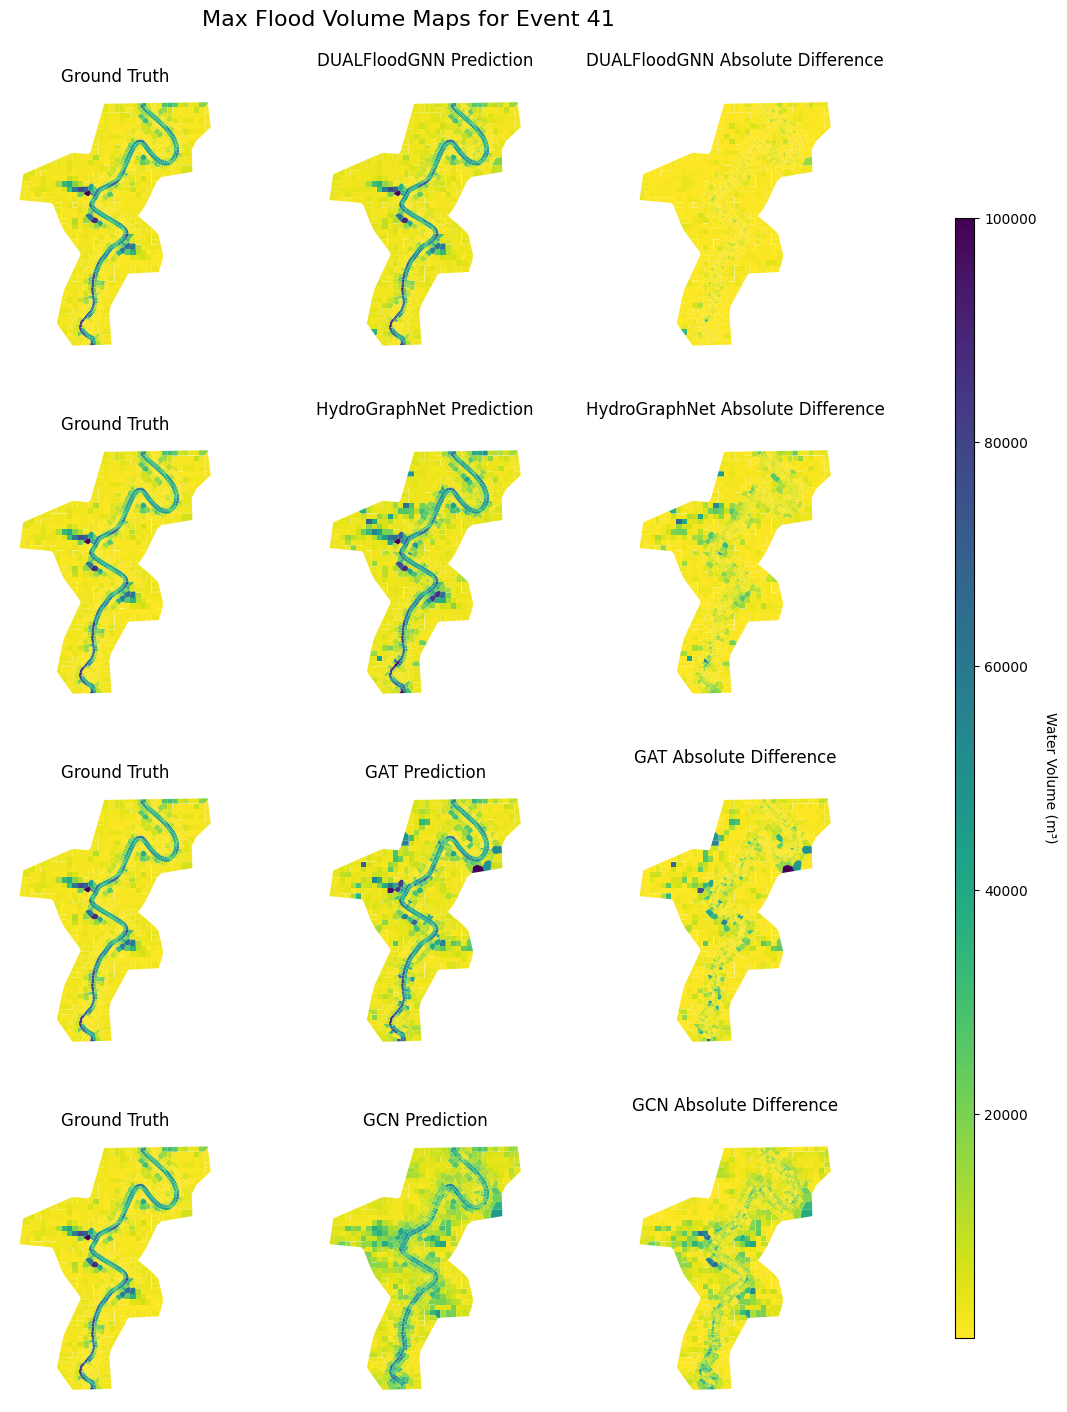

In [25]:
def plot_max_vol_map_difference(metric_paths: list[str],
                                node_df: gpd.GeoDataFrame,
                                ground_truth: np.ndarray,
                                labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    cmap = plt.get_cmap('viridis_r')

    n_cols = 3
    n_rows = len(metric_paths)
    
    fig, axes = plt.subplots(figsize=(13, 4 * n_rows), nrows=n_rows, ncols=n_cols)
    fig.suptitle(f'Max Flood Volume Maps for Event {event_name}', fontsize=16)

    vmin = ground_truth.min()
    vmax = ground_truth.max()

    for i, metric_path in enumerate(metric_paths):
        label = labels[i] if labels is not None else f'Model {i+1}'

        # Column 0: Ground Truth
        plot_obj = plot_cell_map(axes[i, 0], node_df, ground_truth, title='Ground Truth',
                                 cmap=cmap, vmin=vmin, vmax=vmax)

        # Column 1: Prediction
        pred = get_max_flood_map(metric_path, 'pred')
        plot_cell_map(axes[i, 1], node_df, pred, title=f'{label} Prediction', 
                     cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Column 2: Absolute Difference
        diff_map = np.abs(ground_truth - pred)
        plot_cell_map(axes[i, 2], node_df, diff_map, title=f'{label} Absolute Difference', 
                     cmap=cmap, vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
    cbar.set_label('Water Volume (m³)', rotation=270, labelpad=15)
    plt.subplots_adjust(right=0.9, hspace=0.3, wspace=-0.2, top=0.93)

    plt.show()

# Plot all models
plot_max_vol_map_difference(metric_paths=metric_paths,
                            node_df=gpdf,
                            ground_truth=max_flood_map_gt,
                            labels=labels)

In [26]:
def plot_vol_map_at_timestep_for_all_models(metric_paths: list[str],
                                            node_df: gpd.GeoDataFrame,
                                            timestep: int,
                                            labels: list[str] = None):
    ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
    vmin, vmax = ground_truth.min(), ground_truth.max()
    ts_gt_flood_map = ground_truth[timestep]

    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3  # Ground truth, prediction, difference
    nrows = len(metric_paths)  # One row per model
    
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    # Get flood maps for all paths at the specified timestep
    flood_maps = []
    data_shape = None
    for path in metric_paths:
        pred = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        ts_flood_map = pred[timestep]
        flood_maps.append(ts_flood_map)

    # Calculate difference maps
    diff_maps = []
    for map_data in flood_maps:
        diff_map = np.abs(map_data - ts_gt_flood_map)
        diff_maps.append(diff_map)

    cmap = plt.get_cmap('viridis_r')
    fig, ax = plt.subplots(figsize=(13, 4*nrows), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Flood Volume Maps at Timestep {timestep} for Event {event_name}')

    for i, (map_data, diff_map, label) in enumerate(zip(flood_maps, diff_maps, labels)):
        row = i

        # Ground truth
        axis = get_axis_from_subplot(ax, nrows, ncols, row * ncols)
        plot_obj_gt = plot_cell_map(axis, node_df, ts_gt_flood_map, 
                                   title=f'Ground Truth', 
                                   cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Prediction
        axis = get_axis_from_subplot(ax, nrows, ncols, row * ncols + 1)
        plot_obj_pred = plot_cell_map(axis, node_df, map_data, 
                                     title=f'{label} Prediction',
                                     cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Difference (Prediction - Ground Truth)
        axis = get_axis_from_subplot(ax, nrows, ncols, row * ncols + 2)
        plot_obj_diff = plot_cell_map(axis, node_df, diff_map, 
                                     title=f'Absolute Difference',
                                     cmap=cmap, vmin=vmin, vmax=vmax)

    # Add colorbars
    if plot_obj_gt is not None:
        # # Colorbar for ground truth and predictions
        # cbar_ax1 = fig.add_axes([0.68, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        # cbar1 = fig.colorbar(plot_obj_pred.collections[0], cax=cbar_ax1)
        # cbar1.set_label('Water Volume (m³)', rotation=270, labelpad=15)

        # Colorbar for differences
        cbar_ax2 = fig.add_axes([0.72, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar2 = fig.colorbar(plot_obj_diff.collections[0], cax=cbar_ax2)
        cbar2.set_label('Volume Difference (m³)', rotation=270, labelpad=15)
    
    plt.subplots_adjust(right=0.7, hspace=0.3, wspace=0)
    plt.show()

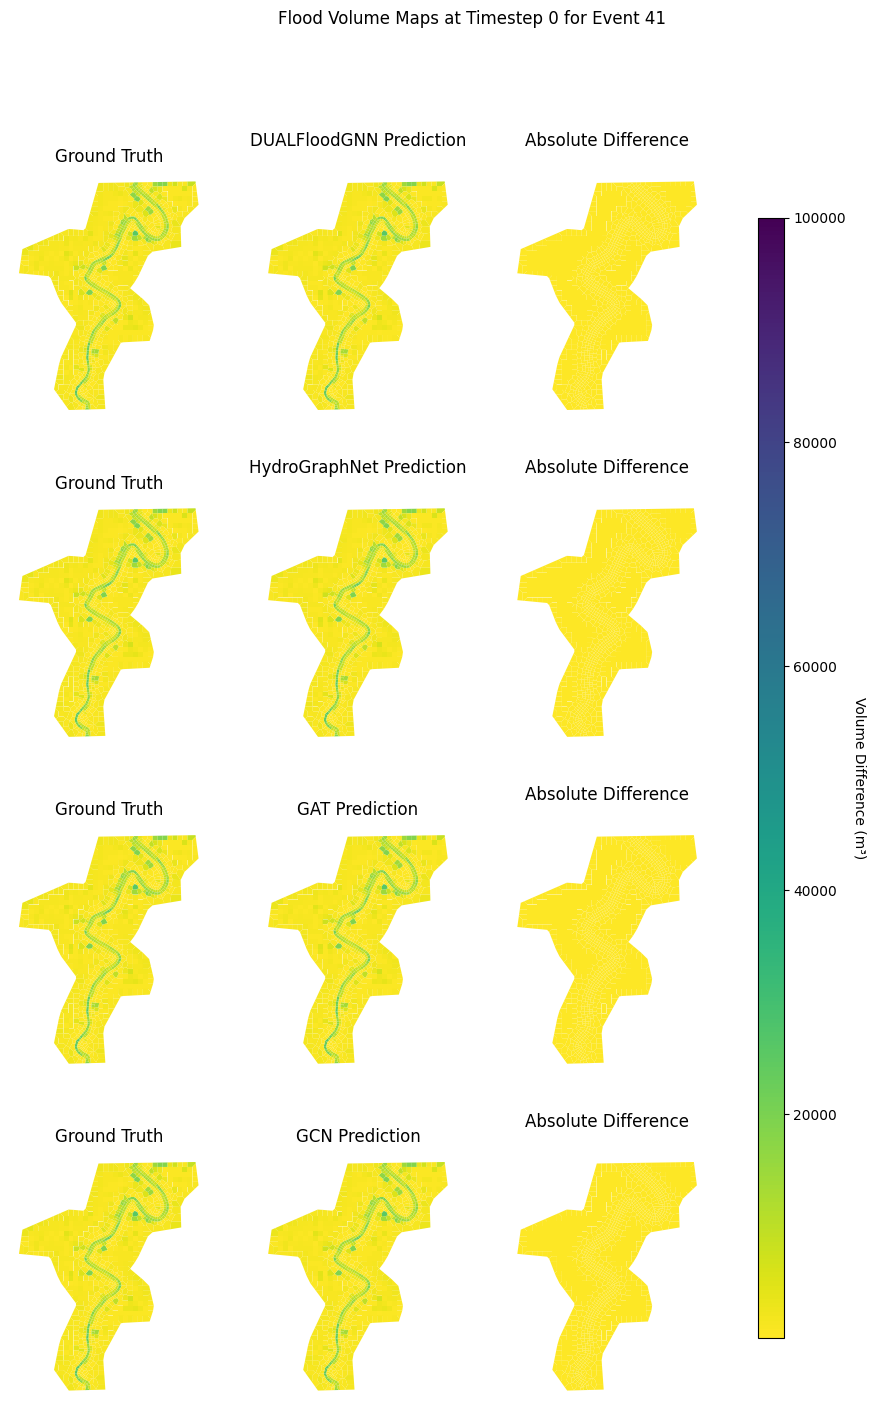

In [27]:
TIMESTEP = 0  # Change this to the desired timestep
plot_vol_map_at_timestep_for_all_models(metric_paths,
                                        gpdf,
                                        timestep=TIMESTEP,
                                        labels=labels)

In [28]:
def get_boundary_condition(config: dict, run_id: str) -> BoundaryCondition:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']

    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
    summary_df = pd.read_csv(dataset_summary_path)
    summary_df = summary_df[summary_df['Run_ID'] == run_id]
    hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

    inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
    outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

    bc = BoundaryCondition(root_dir=root_dir,
                           hec_ras_file=hec_ras_file,
                           inflow_boundary_nodes=inflow_boundary_nodes,
                           outflow_boundary_nodes=outflow_boundary_nodes,
                           saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
    return bc

# def get_volume_theshold_per_cell(config: dict, constant_values_path: str, run_id: str, percent_of_area: float = 0.05) -> np.ndarray:
#     dataset_parameters = config['dataset_parameters']

#     # Get area
#     constant_values = np.load(constant_values_path)
#     static_nodes = constant_values['static_nodes']
#     static_nodes = np.load(constant_values_path)['static_nodes']
#     area_idx = FloodEventDataset.STATIC_NODE_FEATURES.index('area')
#     area = static_nodes[:, area_idx]

#     # Denormalize
#     root_dir = dataset_parameters['root_dir']
#     if dataset_parameters['normalize']:
#         features_stats_file = dataset_parameters['features_stats_file']
#         normalizer = DatasetNormalizer(mode='test', root_dir=root_dir, features_stats_file=features_stats_file)
#         area = normalizer.denormalize('area', area)

#     # Filter out boundary nodes
#     bc = get_boundary_condition(config, run_id)
#     non_boundary_nodes_mask = ~bc.boundary_nodes_mask
#     area = area[non_boundary_nodes_mask, None]

#     # Get threshold
#     threshold_per_cell = area * percent_of_area
#     return threshold_per_cell

# def convert_water_to_binary(water_volume: np.ndarray, water_threshold: np.ndarray) -> np.ndarray:
#     return (water_volume > water_threshold).astype(int).squeeze()

# def plot_binary_max_flood_map_for_all_models(metric_paths: list[str],
#                                              node_df: gpd.GeoDataFrame,
#                                              water_threshold: np.ndarray,
#                                              ground_truth: np.ndarray = None,
#                                              labels: list[str] = None):
#     event_name = metric_paths[0].split('/')[-1].split('_')[-3]
#     ncols = 3
#     num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
#     nrows = (num_plots + ncols - 1) // ncols
#     assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

#     cmap = plt.get_cmap('seismic_r')
#     if labels is None:
#         labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

#     fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
#     fig.suptitle(f'Binary max flood maps for event {event_name}')
#     index = 0

#     # Get max flood maps for all paths
#     max_flood_maps = []
#     data_shape = None
#     for path in metric_paths:
#         pred = get_max_flood_map(path, 'pred')
#         if data_shape is None:
#             data_shape = pred.shape
#         assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

#         pred = convert_water_to_binary(pred, water_threshold)
#         max_flood_maps.append(pred)

#     # Plot ground truth
#     if ground_truth is not None:
#         axis = get_axis_from_subplot(ax, nrows, ncols, index)
#         plot_cell_map(axis, node_df, ground_truth, title='Ground Truth', cmap=cmap)
#         index += 1

#     # Plot predictions
#     for i, map_data in enumerate(max_flood_maps):
#         axis = get_axis_from_subplot(ax, nrows, ncols, index)
#         plot_cell_map(axis, node_df, map_data, title=labels[i], cmap=cmap)
#         index += 1

#     # Add shared legend for binary values
#     legend_elements = [
#         Patch(facecolor=cmap(0.0), label='Not Flooded'),
#         Patch(facecolor=cmap(1.0), label='Flooded')
#     ]
    
#     fig.legend(handles=legend_elements, 
#                 loc='center right', 
#                 bbox_to_anchor=(0.98, 0.5),
#                 frameon=True,
#                 fancybox=True,
#                 shadow=True)

#     hide_remaining_axes(ax, index, nrows, ncols)
#     plt.tight_layout()
#     plt.subplots_adjust(right=0.88)
#     plt.show()

In [29]:
# PERCENT_OF_AREA = 0.05

# water_threshold = get_volume_theshold_per_cell(config, constant_values_path, RUN_ID, percent_of_area=PERCENT_OF_AREA)
# binary_max_flood_map_gt = max_flood_map_gt > water_threshold
# print(f'Ground truth num flooded cells: {binary_max_flood_map_gt.sum()}')
# print(f'Calculating CSI (threshold = ({PERCENT_OF_AREA})) for max flood maps...')
# binary_gt_max_map = torch.Tensor(binary_max_flood_map_gt).to(torch.bool)
# for i, path in enumerate(metric_paths):
#     pred_max_flood_map = get_max_flood_map(path, 'pred')
#     binary_pred_max_map = torch.Tensor((pred_max_flood_map > water_threshold)).to(torch.bool)
#     csi = metric_utils.CSI(binary_pred_max_map, binary_gt_max_map)
#     label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
#     print(f'\tCSI for {label}: {csi:.4f} (Num flooded cells: {binary_pred_max_map.sum().item()})')

In [30]:
# plot_binary_max_flood_map_for_all_models(metric_paths,
#                                          gpdf,
#                                          water_threshold,
#                                          labels=labels,
#                                          ground_truth=binary_max_flood_map_gt)

In [31]:
def get_max_flow_map(metric_path: str, property: str) -> np.ndarray:
    data = np.load(metric_path, allow_pickle=True)
    if property not in data or data[property] is None or len(data[property]) == 0:
        return None
    
    per_edge_flow = data[property]
    per_edge_flow = np.abs(per_edge_flow) # Use absolute value as we don't care about direction
    max_flow_map = per_edge_flow.max(axis=0)
    return max_flow_map

def get_edge_df(config: dict, run_id: str, no_ghost: bool = True) -> gpd.GeoDataFrame:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']
    edges_shp_file = dataset_parameters['edges_shp_file']
    edges_shp_path = os.path.join(root_dir, 'raw', edges_shp_file)
    link_df = gpd.read_file(edges_shp_path)

    if no_ghost:
        dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
        dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
        summary_df = pd.read_csv(dataset_summary_path)
        summary_df = summary_df[summary_df['Run_ID'] == run_id]
        hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

        inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
        outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

        bc = BoundaryCondition(root_dir=root_dir,
                               hec_ras_file=hec_ras_file,
                               inflow_boundary_nodes=inflow_boundary_nodes,
                               outflow_boundary_nodes=outflow_boundary_nodes,
                               saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
        is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
        boundary_nodes = np.concat([np.array(inflow_boundary_nodes), np.array(outflow_boundary_nodes)])
        is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
        link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

        assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
        assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

    return link_df

def plot_max_flow_map_for_all_models(metric_paths: list[str],
                                     edge_df: gpd.GeoDataFrame,
                                     ground_truth: np.ndarray = None,
                                     labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    cmap = plt.get_cmap('viridis_r')
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max flow maps for event {event_name}')
    index = 0

    # Get max flow maps for all paths
    max_flow_maps = []
    vmin = np.inf if ground_truth is None else ground_truth.min()
    vmax = -np.inf if ground_truth is None else ground_truth.max()
    data_shape = None
    for path in metric_paths:
        pred = get_max_flow_map(path, 'edge_pred')
        if pred is None:
            max_flow_maps.append(None)
            continue

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        # vmin = min(vmin, pred.min())
        # vmax = max(vmax, pred.max())
        max_flow_maps.append(pred)

    # Plot ground truth
    plot_obj = None
    if ground_truth is not None:
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, edge_df, ground_truth, title='Ground Truth', 
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    # Plot predictions
    for i, map_data in enumerate(max_flow_maps):
        if map_data is None:
            continue

        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, edge_df, map_data, title=labels[i],
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    if plot_obj is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
        cbar.set_label('Water Flow (m³/s)', rotation=270, labelpad=15)
    
    hide_remaining_axes(ax, index, nrows, ncols)
    plt.subplots_adjust(right=0.9)
    plt.show()

In [32]:
flow_gt_path_idx = 0

if INCLUDE_EDGES:
    max_flow_map_gt = get_max_flow_map(metric_paths[flow_gt_path_idx], 'edge_target')

    print(f'Calculating RMSE for max flow maps...')
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)
        if 'edge_pred' not in data or data['edge_pred'] is None or len(data['edge_pred']) == 0:
            print(f"Skipping RMSE calculation for {path} as 'edge_pred' not found in the data.")
            continue

        pred_max_flow_map = torch.Tensor(get_max_flow_map(path, 'edge_pred'))
        rmse = metric_utils.RMSE(pred_max_flow_map, torch.Tensor(max_flow_map_gt))
        label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        print(f'\tRMSE for {label}: {rmse:.4f}')

In [33]:
if INCLUDE_EDGES:
    edge_df = get_edge_df(config, RUN_ID, no_ghost=True)
    plot_max_flow_map_for_all_models(metric_paths,
                                    edge_df,
                                    labels=labels,
                                    ground_truth=max_flow_map_gt)

In [34]:
def plot_max_flow_map_difference(metric_path: str,
                                 edge_df: gpd.GeoDataFrame,
                                 ground_truth: np.ndarray,
                                 label: str = None):

    event_name = metric_path.split('/')[-1].split('_')[-3]
    cmap = plt.get_cmap('viridis_r')

    fig, ax = plt.subplots(figsize=(10,5), ncols=3)
    fig.suptitle(f'Max flow map differences for event {event_name}')

    vmin = ground_truth.min()
    vmax = ground_truth.max()

    # Plot ground truth
    plot_obj = plot_cell_map(ax[0], edge_df, ground_truth, title='Ground Truth', 
                                cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Plot prediction
    pred = get_max_flow_map(metric_path, 'edge_pred')
    title = label if label is not None else 'Prediction'
    plot_cell_map(ax[1], edge_df, pred, title=title, cmap=cmap, vmin=vmin, vmax=vmax)

    # Plot difference
    diff_map = np.abs(ground_truth - pred)
    plot_cell_map(ax[2], edge_df, diff_map, title='Difference', cmap=cmap, vmin=vmin, vmax=vmax)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
    cbar.set_label('Water Flow (m³/s)', rotation=270, labelpad=15)
    plt.subplots_adjust(right=0.9)

    # plt.tight_layout()
    plt.show()

PATH_IDX = 0

if INCLUDE_EDGES:
    plot_max_flow_map_difference(metric_path=metric_paths[PATH_IDX],
                                edge_df=edge_df,
                                ground_truth=max_flow_map_gt,
                                label=labels[PATH_IDX] if labels is not None else None)

### Water Depth Analysis

In [35]:
RUN_ID = 41


vol_metric_paths = [
    f'physics_informed/test/NodeEdgeGNN_2025-10-05_05-29-23_global_local_runid_{RUN_ID}_test_metrics.npz',
]
vol_metric_labels = ['DUALFloodGNN']

# vol_metric_paths = [
#     f'physics_informed/test/NodeEdgeGNN_2025-10-05_05-29-23_global_local_runid_{RUN_ID}_test_metrics.npz',
    # f'physics_informed/test/NodeEdgeGNN_2025-10-03_12-34-28_global_runid_{RUN_ID}_test_metrics.npz',
    # f'physics_informed/test/NodeEdgeGNN_2025-10-04_14-56-06_local_runid_{RUN_ID}_test_metrics.npz',
    # f'physics_informed/test/NodeEdgeGNN_2025-10-02_12-29-08_base_runid_{RUN_ID}_test_metrics.npz',
# ]
# vol_metric_labels = ['Global and Local', 'Global', 'Local', 'Base']

wd_metric_paths = [
    f'baseline/hydrographnet_test_wd/HydroGraphNet_runid_{RUN_ID}_metrics.npz',
    f'baseline/swegnn_wd/SWEGNN_run_id_{RUN_ID}_metrics.npz',
]
wd_metric_labels = ['HydroGraphNet', 'SWE-GNN']

wd_labels = [*vol_metric_labels, *wd_metric_labels]

In [36]:
# Double check targets are the same
EPS = 1e-1
comparison_target = None
for path in wd_metric_paths:
    print('Checking target for', path)
    data = np.load(path, allow_pickle=True)
    target = data['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

wd_ground_truth = np.load(wd_metric_paths[0], allow_pickle=True)['target']

Checking target for baseline/hydrographnet_test_wd/HydroGraphNet_runid_41_metrics.npz
Checking target for baseline/swegnn_wd/SWEGNN_run_id_41_metrics.npz


In [37]:
def get_hecras_file_path_from_config(config: dict, run_id: str) -> str:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']

    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
    summary_df = pd.read_csv(dataset_summary_path)
    summary_df = summary_df[summary_df['Run_ID'] == run_id]

    hec_ras_file = summary_df['HECRAS_Filepath'].values[0]
    hec_ras_file_path = os.path.join(root_dir, 'raw', hec_ras_file)
    return hec_ras_file_path

def get_node_elevation(constant_values_path: str, run_id: int) -> np.ndarray:
    dataset_parameters = config['dataset_parameters']

    # Get elevation
    constant_values = np.load(constant_values_path)
    static_nodes = constant_values['static_nodes']
    static_nodes = np.load(constant_values_path)['static_nodes']
    elevation_idx = FloodEventDataset.STATIC_NODE_FEATURES.index('elevation')
    elevation = static_nodes[:, elevation_idx]

    # Denormalize
    root_dir = dataset_parameters['root_dir']
    if dataset_parameters['normalize']:
        features_stats_file = dataset_parameters['features_stats_file']
        normalizer = DatasetNormalizer(mode='test', root_dir=root_dir, features_stats_file=features_stats_file)
        elevation = normalizer.denormalize('elevation', elevation)

    # Filter out boundary nodes
    bc = get_boundary_condition(config, run_id)
    non_boundary_nodes_mask = ~bc.boundary_nodes_mask
    elevation = elevation[non_boundary_nodes_mask, None]

    return elevation

In [38]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)
hec_ras_file_path = get_hecras_file_path_from_config(config, RUN_ID)
print(f'Using HEC-RAS file: {hec_ras_file_path} for run ID {RUN_ID}')

elevation = get_node_elevation(constant_values_path, RUN_ID)

Using HEC-RAS file: data/datasets\raw\HEC-RAS Results/Model_01.p46.hdf for run ID 41


In [39]:
wd_predictions = []
for i, path in enumerate(vol_metric_paths):
    vol_pred = np.load(path, allow_pickle=True)['pred']
    print(f'Interpolating water level from volume for path number {i+1}...')
    wl_pred = metric_utils.interpolate_wl_from_vol(vol_pred, hec_ras_file_path)

    repeat_elevation = np.repeat(elevation[None, :, :], wl_pred.shape[0], axis=0)
    wd_pred = wl_pred - repeat_elevation
    wd_pred = np.clip(wd_pred, a_min=0, a_max=None)
    wd_predictions.append(wd_pred)

for path in wd_metric_paths:
    wd_pred = np.load(path, allow_pickle=True)['pred']
    wd_predictions.append(wd_pred)

Interpolating water level from volume for path number 1...
Completed interpolation for timestep 0/574
Completed interpolation for timestep 100/574
Completed interpolation for timestep 200/574
Completed interpolation for timestep 300/574
Completed interpolation for timestep 400/574
Completed interpolation for timestep 500/574


In [40]:
print(f'Calculating overall water depth metrics for event {RUN_ID}...')
print('RMSE:')
for wd_pred, label in zip(wd_predictions, wd_labels):
    rmse = metric_utils.RMSE(torch.Tensor(wd_pred), torch.Tensor(wd_ground_truth))
    print(f'\t{label}: {rmse:.4f}')

print('MAE:')
for wd_pred, label in zip(wd_predictions, wd_labels):
    mae = metric_utils.MAE(torch.Tensor(wd_pred), torch.Tensor(wd_ground_truth))
    print(f'\t{label}: {mae:.4f}')

print('NSE:')
for wd_pred, label in zip(wd_predictions, wd_labels):
    nse = metric_utils.NSE(torch.Tensor(wd_pred), torch.Tensor(wd_ground_truth))
    print(f'\t{label}: {nse:.4f}')

thresholds = [0.05, 0.3]
for threshold in thresholds:
    print(f'CSI (threshold = {threshold} m):')
    for wd_pred, label in zip(wd_predictions, wd_labels):
        binary_wd_pred = torch.Tensor(wd_pred) > threshold
        binary_wd_gt = torch.Tensor(wd_ground_truth) > threshold
        csi = metric_utils.CSI(binary_wd_pred, binary_wd_gt)
        print(f'\t{label}: {csi:.4f}')

Calculating overall water depth metrics for event 41...
RMSE:
	DUALFloodGNN: 0.2027
	HydroGraphNet: 0.5168
	SWE-GNN: 1.0055
MAE:
	DUALFloodGNN: 0.0552
	HydroGraphNet: 0.1622
	SWE-GNN: 0.5912
NSE:
	DUALFloodGNN: 0.9790
	HydroGraphNet: 0.8637
	SWE-GNN: 0.4839
CSI (threshold = 0.05 m):
	DUALFloodGNN: 0.8767
	HydroGraphNet: 0.5214
	SWE-GNN: 0.1994
CSI (threshold = 0.3 m):
	DUALFloodGNN: 0.9020
	HydroGraphNet: 0.8028
	SWE-GNN: 0.1990


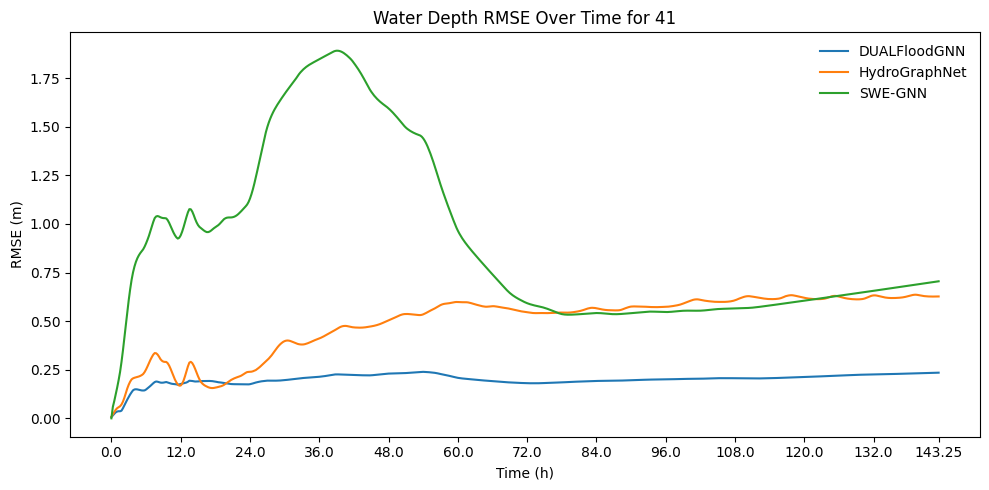

In [41]:
def plot_wd_rmse_over_time(wd_predictions: list[np.ndarray],
                           metric_paths: list[str],
                           ground_truth: np.ndarray,
                           labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    if labels is None:
        labels = [f'Model_{i}' for i in range(len(wd_predictions))]

    plt.figure(figsize=(10, 5))
    
    # Calculate RMSE for each timestep for each prediction
    for i, wd_pred in enumerate(wd_predictions):
        rmse_per_timestep = []
        for t in range(wd_pred.shape[0]):
            rmse_t = metric_utils.RMSE(torch.Tensor(wd_pred[t]), torch.Tensor(ground_truth[t]))
            rmse_per_timestep.append(rmse_t.item())
        
        plt.plot(rmse_per_timestep, label=labels[i], color=f'C{i % 10}')
    
    plt.title(f'Water Depth RMSE Over Time for {event_name}')
    plt.ylabel('RMSE (m)')
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel('Time (h)')

    plt.legend(framealpha=0)
    plt.tight_layout()
    plt.show()

plot_wd_rmse_over_time(wd_predictions,
                       vol_metric_paths, # Only our models have timestamps
                       wd_ground_truth,
                       labels=wd_labels)

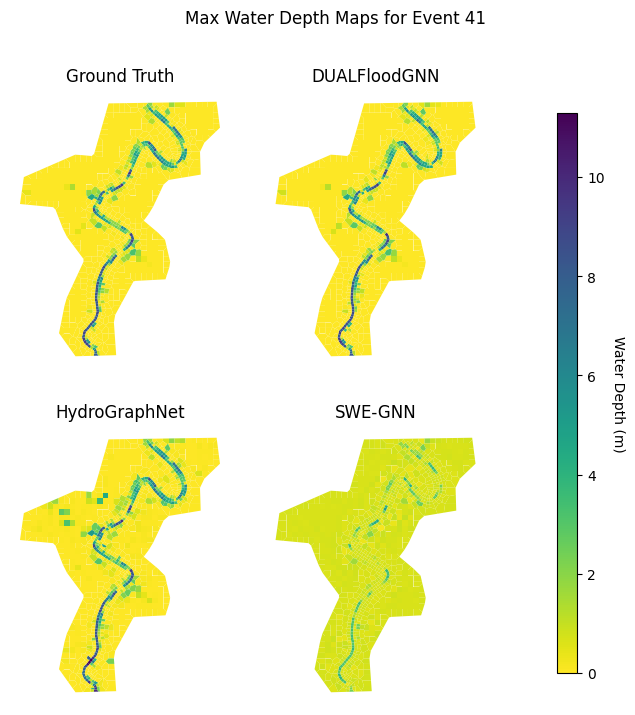

In [42]:
def plot_max_wd_map_for_all_models(wd_predictions: list[np.ndarray],
                                   node_df: gpd.GeoDataFrame,
                                   ground_truth: np.ndarray = None,
                                   labels: list[str] = None,
                                   run_id: int = None):
    event_name = f"Event {run_id}" if run_id is not None else "event"
    ncols = 2
    num_plots = len(wd_predictions) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(wd_predictions) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(wd_predictions)} predictions"

    cmap = plt.get_cmap('viridis_r')
    if labels is None:
        labels = [f'Model_{i}' for i in range(len(wd_predictions))]

    fig, ax = plt.subplots(figsize=(10,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max Water Depth Maps for {event_name}')
    index = 0

    # Get max water depth maps for all predictions
    if ground_truth is not None:
        gt_max_depth_map = ground_truth.max(axis=0) 

    max_depth_maps = []
    vmin = np.inf if ground_truth is None else gt_max_depth_map.min()
    vmax = -np.inf if ground_truth is None else gt_max_depth_map.max()
    data_shape = None
    for wd_pred in wd_predictions:
        pred = wd_pred.max(axis=0)
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        vmin = min(vmin, pred.min())
        vmax = max(vmax, pred.max())
        max_depth_maps.append(pred)

    # Plot ground truth
    plot_obj = None
    if ground_truth is not None:
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, node_df, gt_max_depth_map, title='Ground Truth', 
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    # Plot predictions
    for i, map_data in enumerate(max_depth_maps):
        axis = get_axis_from_subplot(ax, nrows, ncols, index)
        plot_obj = plot_cell_map(axis, node_df, map_data, title=labels[i],
                                 cmap=cmap, vmin=vmin, vmax=vmax)
        index += 1

    if plot_obj is not None:
        cbar_ax = fig.add_axes([0.722, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
        cbar.set_label('Water Depth (m)', rotation=270, labelpad=15)
    
    hide_remaining_axes(ax, index, nrows, ncols)
    plt.subplots_adjust(right=0.7, hspace=0.2, wspace=-0.2)
    plt.show()

plot_max_wd_map_for_all_models(wd_predictions,
                               gpdf,
                               labels=wd_labels,
                               ground_truth=wd_ground_truth,
                               run_id=RUN_ID)

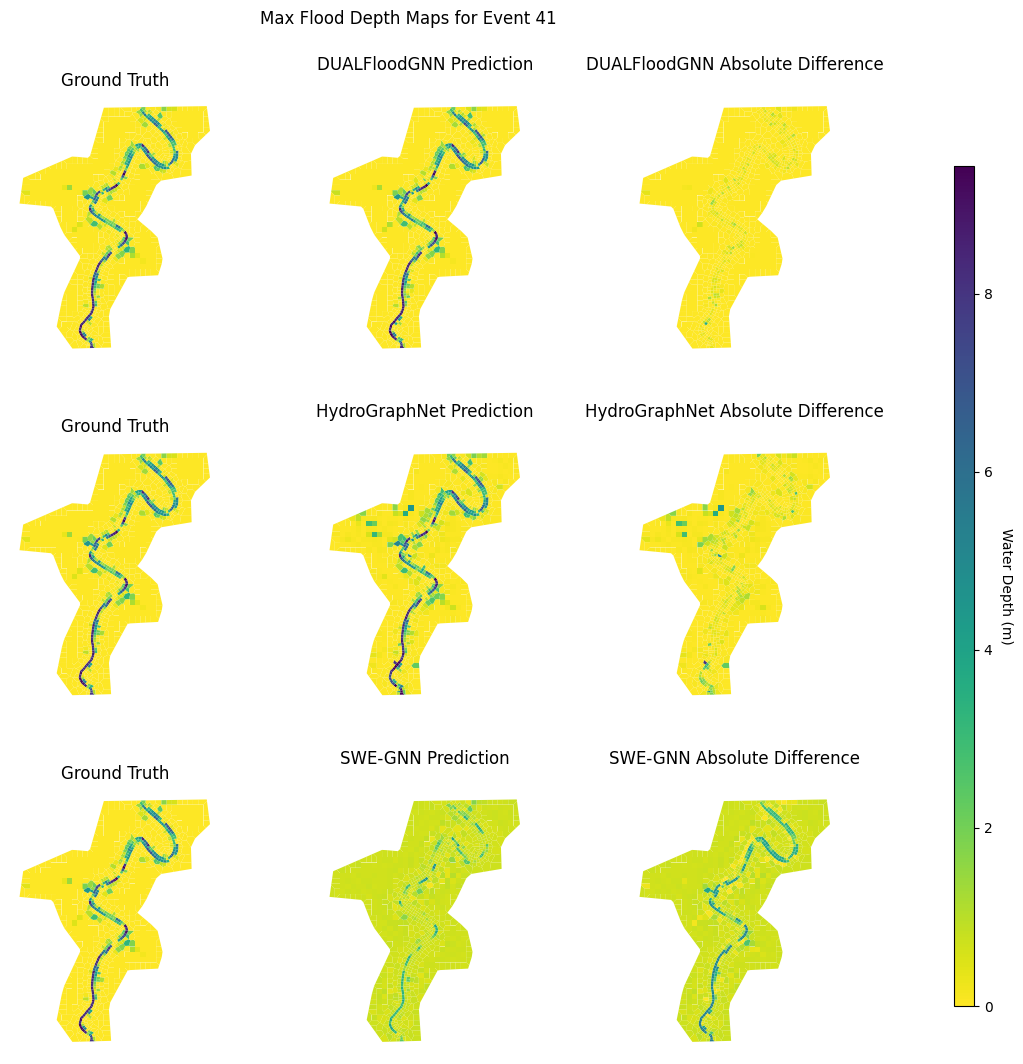

In [43]:
def plot_max_wd_map_difference(wd_predictions: list[np.ndarray],
                               node_df: gpd.GeoDataFrame,
                               ground_truth: np.ndarray = None,
                               labels: list[str] = None,
                               run_id: int = None):
    event_name = f"Event {run_id}" if run_id is not None else "event"
    n_cols = 3
    n_rows = len(wd_predictions)

    cmap = plt.get_cmap('viridis_r')
    if labels is None:
        labels = [f'Model_{i}' for i in range(len(wd_predictions))]

    fig, ax = plt.subplots(figsize=(13, 4 * n_rows), nrows=n_rows, ncols=n_cols)
    fig.suptitle(f'Max Flood Depth Maps for {event_name}')

    # Get max water depth maps for all predictions
    max_depth_maps = []
    data_shape = None
    for wd_pred in wd_predictions:
        pred = wd_pred.max(axis=0)
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"
        max_depth_maps.append(pred)

    if ground_truth is not None:
        gt_max_depth_map = ground_truth.max(axis=0) 

    vmin = gt_max_depth_map.min()
    vmax = gt_max_depth_map.max()

    for i, map_data in enumerate(max_depth_maps):
        label = labels[i] if labels is not None else f'Model {i+1}'

        # Column 0: Ground Truth
        plot_obj = plot_cell_map(ax[i, 0], node_df, gt_max_depth_map, title='Ground Truth',
                                 cmap=cmap, vmin=vmin, vmax=vmax)

        # Column 1: Prediction
        plot_cell_map(ax[i, 1], node_df, map_data, title=f'{label} Prediction', 
                     cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Column 2: Absolute Difference
        diff_map = np.abs(gt_max_depth_map - map_data)
        plot_cell_map(ax[i, 2], node_df, diff_map, title=f'{label} Absolute Difference', 
                     cmap=cmap, vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
    cbar.set_label('Water Depth (m)', rotation=270, labelpad=15)
    plt.subplots_adjust(right=0.9, hspace=0.3, wspace=-0.2, top=0.91)

    plt.show()


plot_max_wd_map_difference(wd_predictions,
                           gpdf,
                           labels=wd_labels,
                           ground_truth=wd_ground_truth,
                           run_id=RUN_ID)

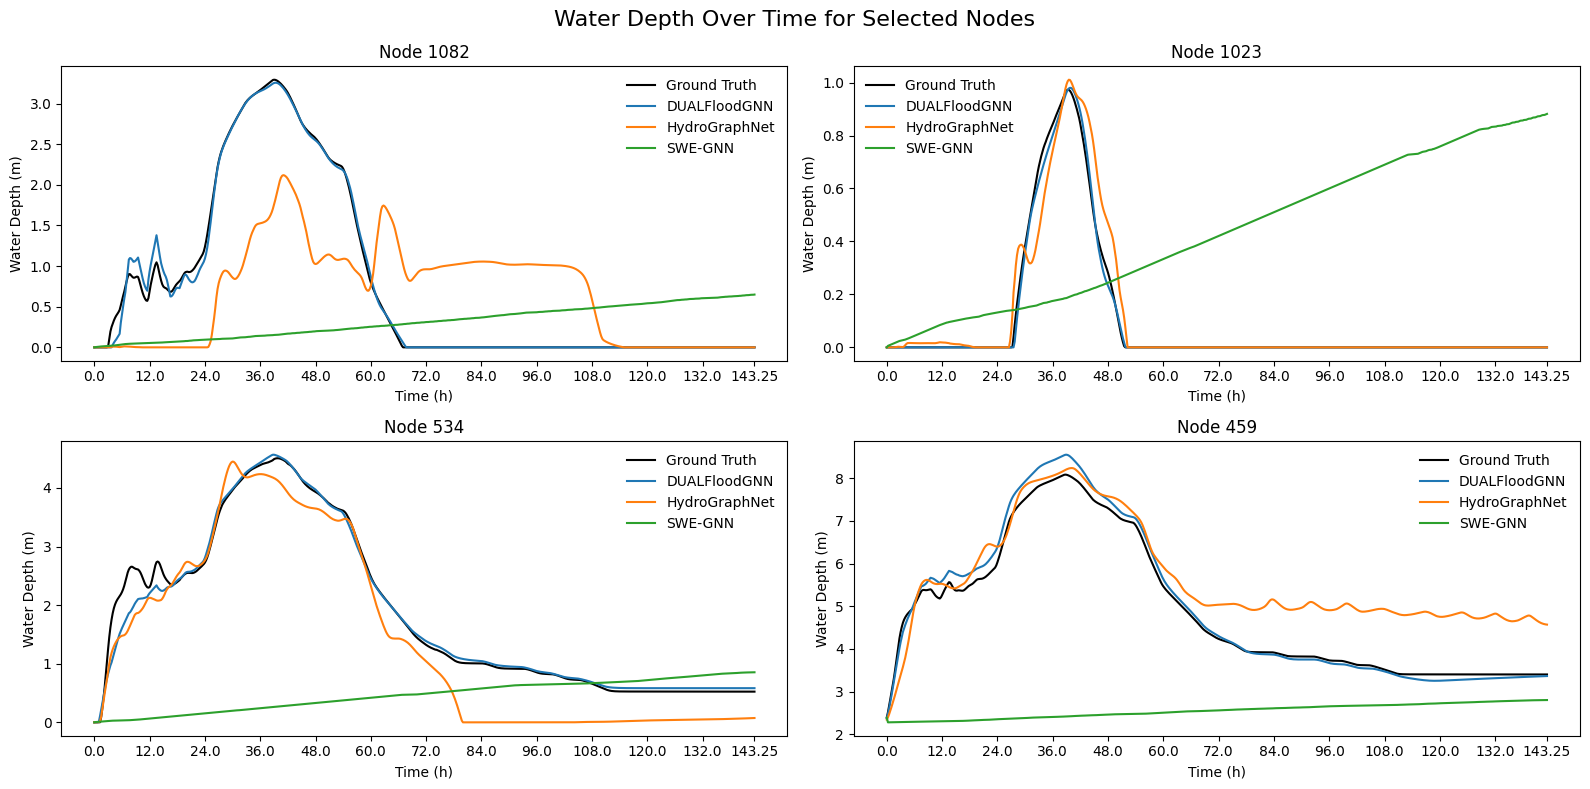

In [44]:
def plot_cell_wd_as_single_plot(pred_list: list[str],
                                 node_idxs: list[int],
                                 wd_ground_truth: np.ndarray = None,
                                 labels: list[str] = None):
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]
    
    # Handle single node_idx for backward compatibility
    if isinstance(node_idxs, int):
        node_idxs = [node_idxs]
    
    # Create subplots for multiple nodes
    num_nodes = len(node_idxs)
    ncols = min(2, num_nodes)  # Max 2 columns
    nrows = (num_nodes + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows))
    if num_nodes == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes if ncols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    x_ticks, x_ticks_labels, xlabel = get_x_ticks_from_timestamps(metric_paths)

    for node_idx_pos, node_idx in enumerate(node_idxs):
        ax = axes[node_idx_pos] if num_nodes > 1 else axes[0]
        handles = []

        ax.set_ylabel('Water Depth (m)')
        ax.set_xlabel('Time (h)')
        ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

        if wd_ground_truth is not None:
           gt_line, = ax.plot(wd_ground_truth[:, node_idx], label='Ground Truth', color='black')
           handles.append(gt_line)

        data_shape = None
        for i, pred in enumerate(pred_list):
            if data_shape is None:
                data_shape = pred.shape
            assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

            line, = ax.plot(pred[:, node_idx], label=labels[i])
            handles.append(line)

        ax.set_title(f'Node {node_idx}')
        ax.legend(handles=handles, labels=['Ground Truth', *labels] if wd_ground_truth is not None else labels, framealpha=0)

    # Hide unused subplots
    for i in range(num_nodes, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Water Depth Over Time for Selected Nodes', fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()

plot_cell_wd_as_single_plot(wd_predictions, node_idxs, wd_ground_truth=wd_ground_truth, labels=wd_labels)